In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp

import datetime

%matplotlib inline
%reload_ext tensorboard

In [2]:
import math

def create_split(df, pct_train, pct_val, batch_size, series):
    length = df.shape[0]
    temp_train_size = find_batch_gcd(math.floor(pct_train * length), batch_size)
    test_size = length - temp_train_size
    train_size = find_batch_gcd(math.floor((1 - pct_val) * temp_train_size), batch_size)
    val_size = temp_train_size - train_size
    df_train = series[:- val_size - test_size]
    df_val = series[- val_size - test_size - window_size:- test_size]
    df_test = series[- test_size - window_size:]
    return df_train, df_val, df_test
    
def find_batch_gcd(length, batch_size):
    while length % batch_size != 0:
        length -= 1
    return length

def create_dataset(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        v = df.iloc[i:(i + window_size)].values
        X.append(v)
        y.append(df["Close"].iloc[i + window_size])
    return np.array(X), np.array(y)

def create_model(nodes, optimizer, dropout, X_train):
    model = keras.Sequential()
    #model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2]))))
    model.add(keras.layers.LSTM(nodes[0], activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(keras.layers.LSTM(nodes[1], activation='relu'))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(1))
    model.compile(loss="mse", optimizer=optimizer)
    return model

def train_model(pair, batch_size, window_size, time, nodes_arr, optimizer, dropout):
    series = pd.read_csv("../data/processed/{}_processed.csv".format(pair))
    
    series = series[series.shape[0] % batch_size:]
    close = series[['Real Close']]
    series = series.drop(['Time', 'Real Close'], axis=1)
    series = series[{'Close', 'EMA_10', 'EMA_100', 'RSI', 'A/D Index',
                     'USD Interest Rate', 'EUR Interest Rate', 'USD_CPI', 'EUR_CPI',
                     'EUR Twitter Sentiment', 'USD Twitter Sentiment'}]
    
    df_train, df_val, df_test = create_split(series, 0.8, 0.2, batch_size, series)
    print(f'df_train.shape {df_train.shape}, df_validation.shape {df_val.shape}, df_test.shape {df_test.shape}')
    
    closeScaler = MinMaxScaler()
    featureScaler = MinMaxScaler()
    df_train = df_train.copy()
    df_val = df_val.copy()
    df_test = df_test.copy()
    df_train.loc[:, ['Close']] = closeScaler.fit_transform(df_train[['Close']])
    df_train.loc[:, ~df_train.columns.isin(['Close'])] = featureScaler.fit_transform(df_train.loc[:, ~df_train.columns.isin(['Close'])])
    df_val.loc[:, ['Close']] = closeScaler.transform(df_val[['Close']])
    df_val.loc[:, ~df_val.columns.isin(['Close'])] = featureScaler.transform(df_val.loc[:, ~df_val.columns.isin(['Close'])])
    df_test.loc[:, ['Close']] = closeScaler.transform(df_test[['Close']])
    df_test.loc[:, ~df_test.columns.isin(['Close'])] = featureScaler.transform(df_test.loc[:, ~df_test.columns.isin(['Close'])])
    
    X_train, y_train = create_dataset(df_train, window_size)
    X_val, y_val = create_dataset(df_val, window_size)
    X_test, y_test = create_dataset(df_test, window_size)

    model = create_model(nodes_arr, optimizer, dropout, X_train)

    log_dir = "logs/tuning/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='epoch', profile_batch=0, histogram_freq=1)

    history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=5,
                    batch_size=batch_size,
                    shuffle=False,
                    callbacks=[tensorboard_callback]
                   )

    return test_model(X_test, y_test, close, model, closeScaler)

def test_model(X_test, y_test, close_df, model, closeScaler):
    y_pred = model.predict(X_test)
    mse = model.evaluate(X_test, y_test)
    print("Test Mean Squared Error:", mse)
    
    index = [i for i in range(y_pred.shape[0])]
    df_predicted = pd.DataFrame(closeScaler.inverse_transform(y_pred), columns=['Close'], index=index)
    df_actual = pd.DataFrame(closeScaler.inverse_transform(y_test.reshape(-1, 1)), columns=['Close'], index=index)
    
    df = pd.DataFrame(close_df['Real Close'][-y_pred.shape[0] - window_size:-window_size])
    df.reset_index(inplace=True, drop=True)
    
    df_predicted['Close'] = df['Real Close'].mul(np.exp(df_predicted['Close'].shift(-1))).shift(1)
    df_actual['Close'] = df['Real Close'].mul(np.exp(df_actual['Close'].shift(-1))).shift(1)
    
    """fig = plt.figure(figsize=(16, 10))
    ax1 = fig.subplots(1)
    ax1.set_title('Predicted Closing Price')
    ax1.set(xlabel='Time', ylabel='Close')
    ax1.plot(df_predicted['Close'][:], label='Prediction')
    ax1.plot(df_actual['Close'][:], label='Actual')
    ax1.legend()"""

df_train.shape (47616, 11), df_validation.shape (12352, 11), df_test.shape (15296, 11)
Epoch 1/5
370/370 [==============================] - 233s 631ms/step - loss: 0.0036 - val_loss: 0.0064
Epoch 2/5
370/370 [==============================] - 255s 690ms/step - loss: 5.8942e-04 - val_loss: 0.0061
Epoch 3/5
370/370 [==============================] - 278s 752ms/step - loss: 5.9035e-04 - val_loss: 0.0039
Epoch 4/5
370/370 [==============================] - 236s 638ms/step - loss: 5.0901e-04 - val_loss: 0.0034
Epoch 5/5
468/468 [==============================] - 28s 60ms/step - loss: 0.0068
Test Mean Squared Error: 0.006785420700907707
df_train.shape (47616, 11), df_validation.shape (12352, 11), df_test.shape (15296, 11)
Epoch 1/5
370/370 [==============================] - 269s 728ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 2/5
370/370 [==============================] - 219s 592ms/step - loss: 0.0013 - val_loss: 7.1357e-04
Epoch 3/5
370/370 [==============================] - 220s 596ms/

370/370 [==============================] - 112s 304ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 2/5
370/370 [==============================] - 114s 307ms/step - loss: 8.6833e-04 - val_loss: 9.0730e-04
Epoch 3/5
370/370 [==============================] - 111s 300ms/step - loss: 4.4510e-04 - val_loss: 5.6830e-04
Epoch 4/5
370/370 [==============================] - 112s 302ms/step - loss: 3.5080e-04 - val_loss: 5.8778e-04
Epoch 5/5
468/468 [==============================] - 23s 48ms/step - loss: 5.7307e-04
Test Mean Squared Error: 0.000573068275116384
df_train.shape (47744, 11), df_validation.shape (12288, 11), df_test.shape (15296, 11)
Epoch 1/5
741/741 [==============================] - 209s 282ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 2/5
741/741 [==============================] - 212s 287ms/step - loss: 4.0116e-04 - val_loss: 0.0020
Epoch 3/5
741/741 [==============================] - 210s 284ms/step - loss: 3.7495e-04 - val_loss: 0.0014
Epoch 4/5
741/741 [===================

<ipython-input-2-0471ae7ed060>:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 10))


df_train.shape (47744, 11), df_validation.shape (12288, 11), df_test.shape (15296, 11)
Epoch 1/5
741/741 [==============================] - 160s 215ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 2/5
741/741 [==============================] - 152s 205ms/step - loss: 3.9236e-04 - val_loss: 0.0027
Epoch 3/5
741/741 [==============================] - 160s 216ms/step - loss: 3.7373e-04 - val_loss: 0.0019
Epoch 4/5
741/741 [==============================] - 157s 211ms/step - loss: 3.5993e-04 - val_loss: 0.0014
Epoch 5/5
468/468 [==============================] - 24s 51ms/step - loss: 0.0020
Test Mean Squared Error: 0.0019911089912056923
df_train.shape (47744, 11), df_validation.shape (12288, 11), df_test.shape (15296, 11)
Epoch 1/5
741/741 [==============================] - 164s 222ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 2/5
741/741 [==============================] - 161s 218ms/step - loss: 8.4513e-04 - val_loss: 6.6663e-04
Epoch 3/5
741/741 [==============================] - 165s 2

467/467 [==============================] - 80s 172ms/step - loss: 5.3084e-04
Test Mean Squared Error: 0.0005308385589160025
df_train.shape (47776, 11), df_validation.shape (12288, 11), df_test.shape (15264, 11)
Epoch 1/5
1483/1483 [==============================] - 586s 395ms/step - loss: 0.0032 - val_loss: 7.0660e-04
Epoch 2/5
1483/1483 [==============================] - 591s 398ms/step - loss: 5.3760e-04 - val_loss: 6.4450e-04
Epoch 3/5
1483/1483 [==============================] - 574s 387ms/step - loss: 3.5087e-04 - val_loss: 6.0927e-04
Epoch 4/5
1483/1483 [==============================] - 558s 376ms/step - loss: 3.2726e-04 - val_loss: 5.2267e-04
Epoch 5/5
467/467 [==============================] - 66s 142ms/step - loss: 3.5864e-04
Test Mean Squared Error: 0.0003586418752092868
df_train.shape (47776, 11), df_validation.shape (12288, 11), df_test.shape (15264, 11)
Epoch 1/5
1483/1483 [==============================] - 261s 176ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 2/5
1483/

2968/2968 [==============================] - 895s 302ms/step - loss: 3.5092e-04 - val_loss: 0.0010
Epoch 3/5
2968/2968 [==============================] - 880s 297ms/step - loss: 3.4688e-04 - val_loss: 6.5502e-04
Epoch 4/5
2968/2968 [==============================] - 881s 297ms/step - loss: 3.4280e-04 - val_loss: 5.2406e-04
Epoch 5/5
467/467 [==============================] - 61s 131ms/step - loss: 3.1128e-04
Test Mean Squared Error: 0.00031128188129514456
df_train.shape (47808, 11), df_validation.shape (12272, 11), df_test.shape (15264, 11)
Epoch 1/5
2968/2968 [==============================] - 900s 303ms/step - loss: 0.0010 - val_loss: 7.5382e-04
Epoch 2/5
2968/2968 [==============================] - 879s 296ms/step - loss: 3.4748e-04 - val_loss: 6.9162e-04
Epoch 3/5
2968/2968 [==============================] - 876s 295ms/step - loss: 3.2651e-04 - val_loss: 5.7029e-04
Epoch 4/5
2968/2968 [==============================] - 887s 299ms/step - loss: 3.2532e-04 - val_loss: 5.4399e-04
Epoch

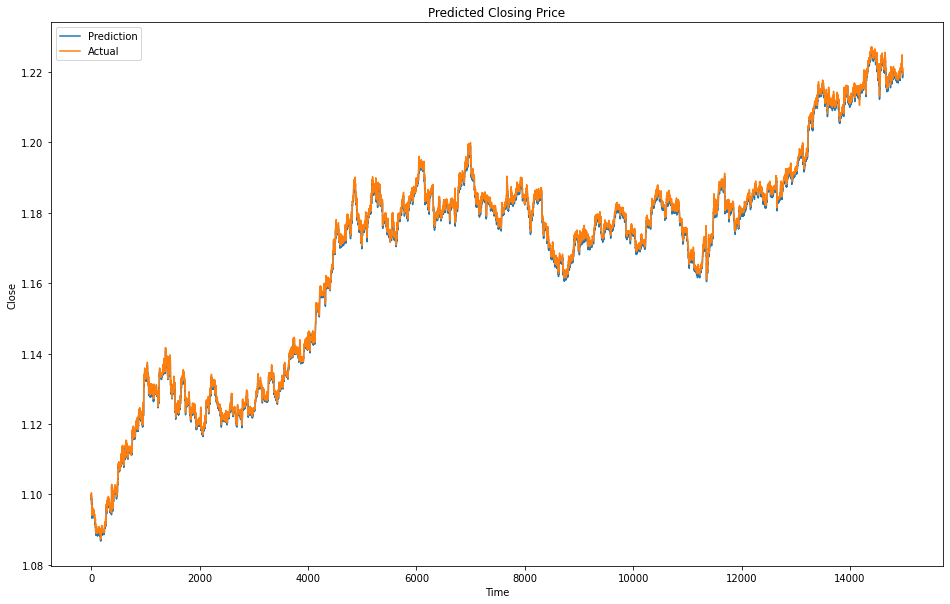

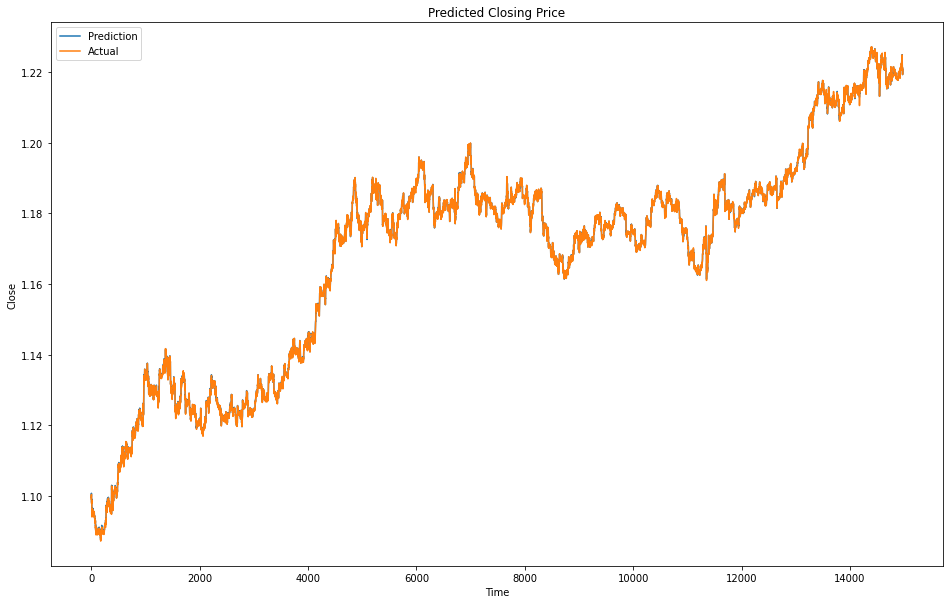

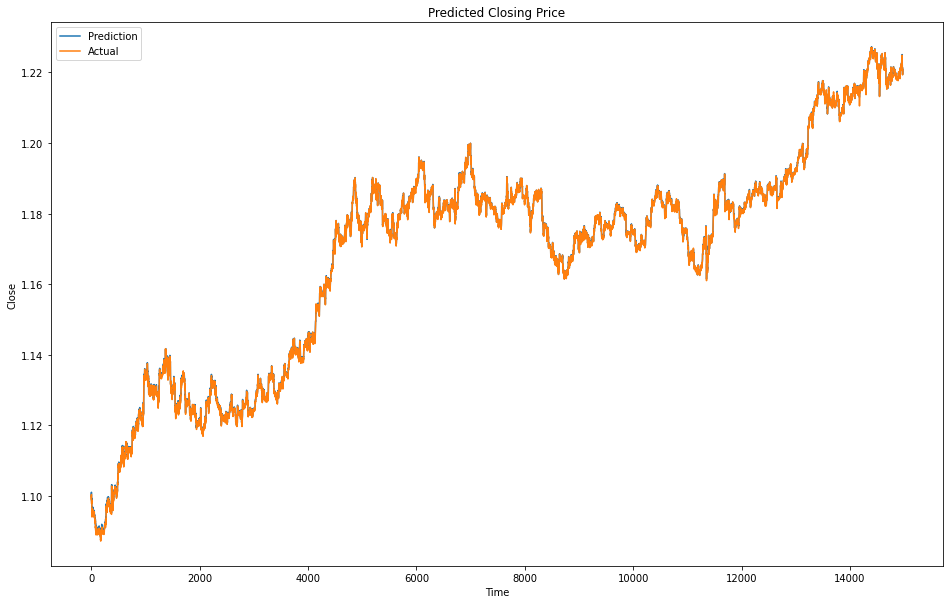

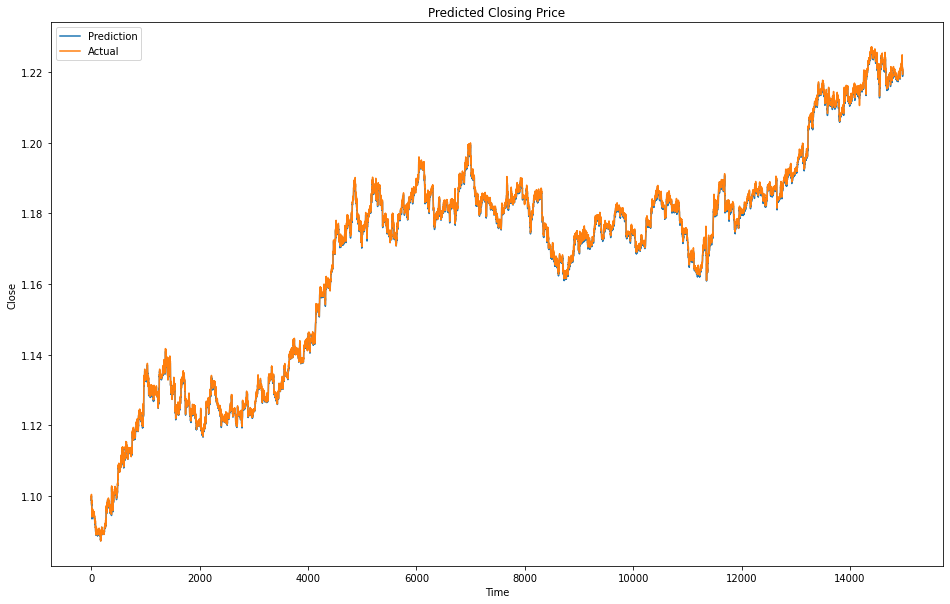

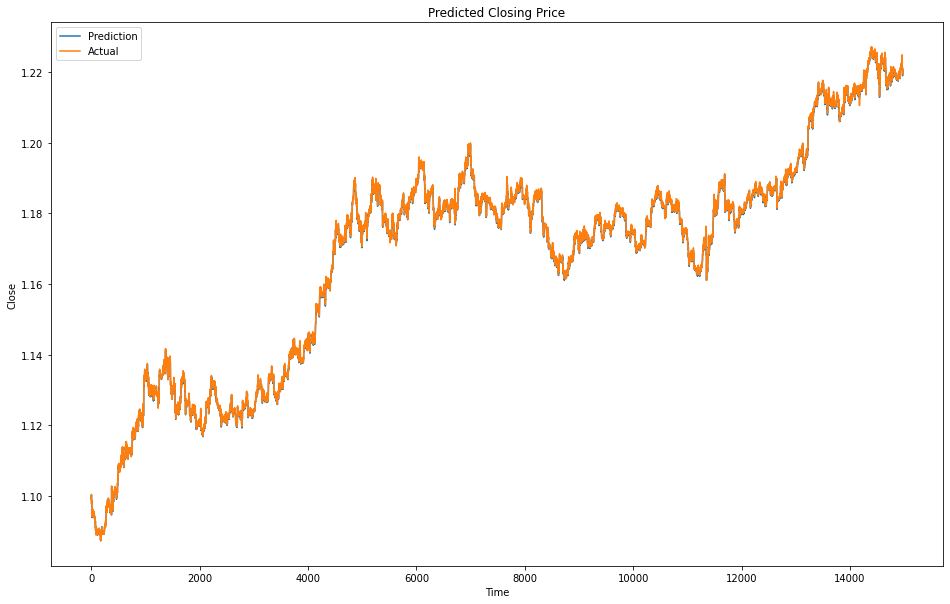

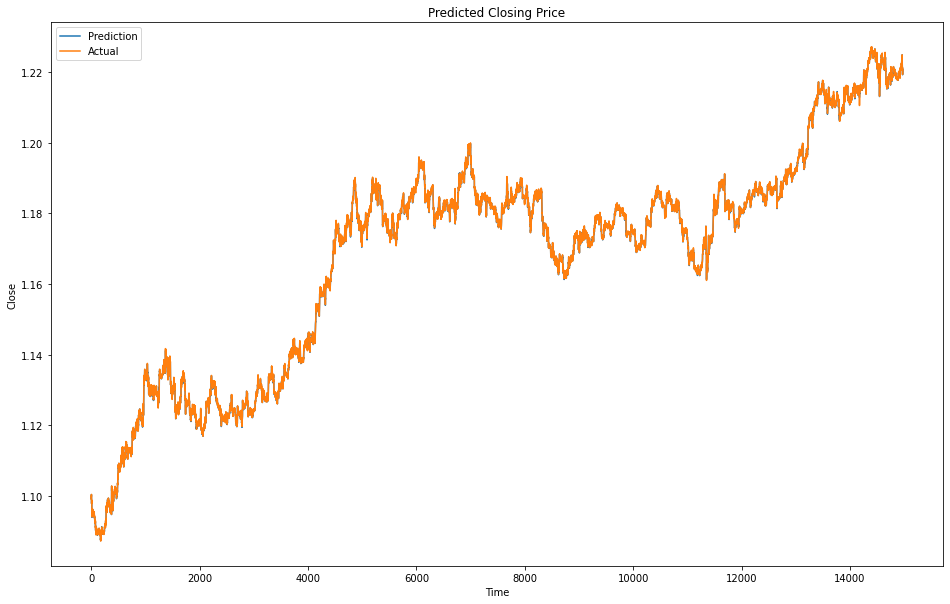

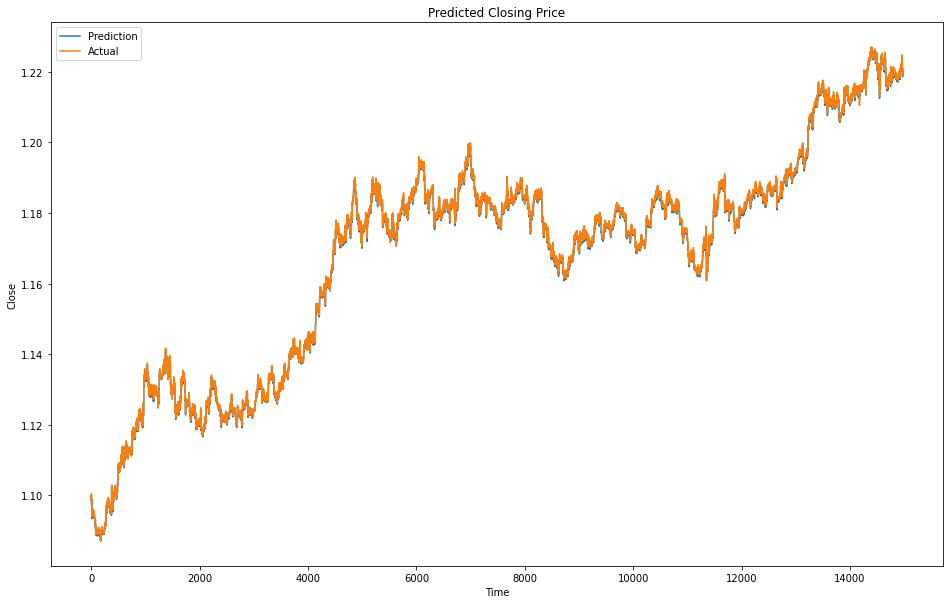

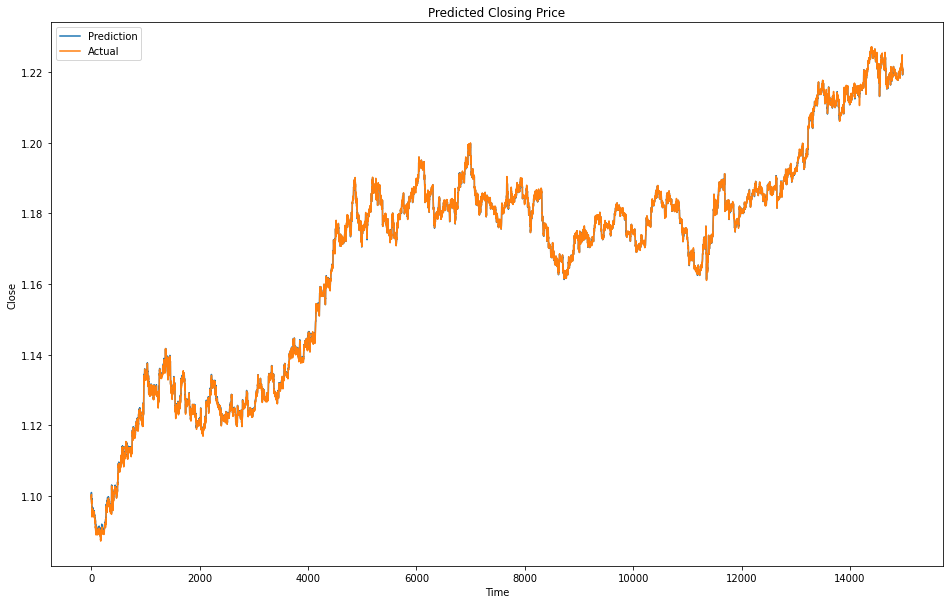

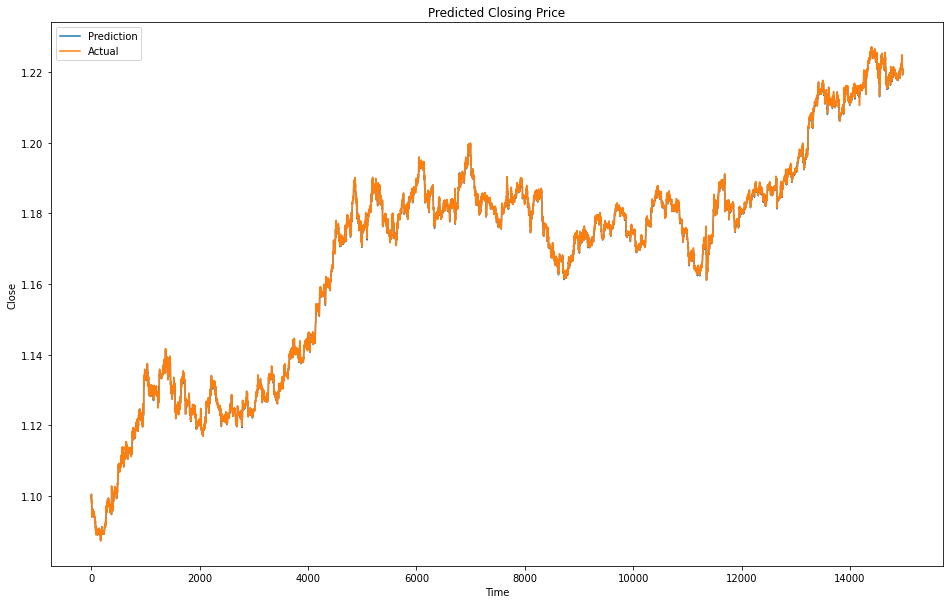

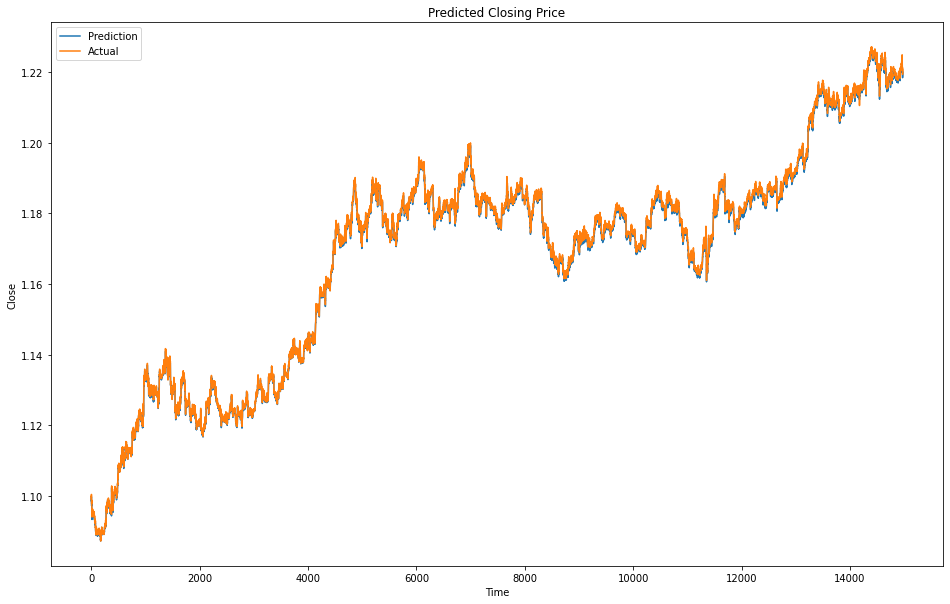

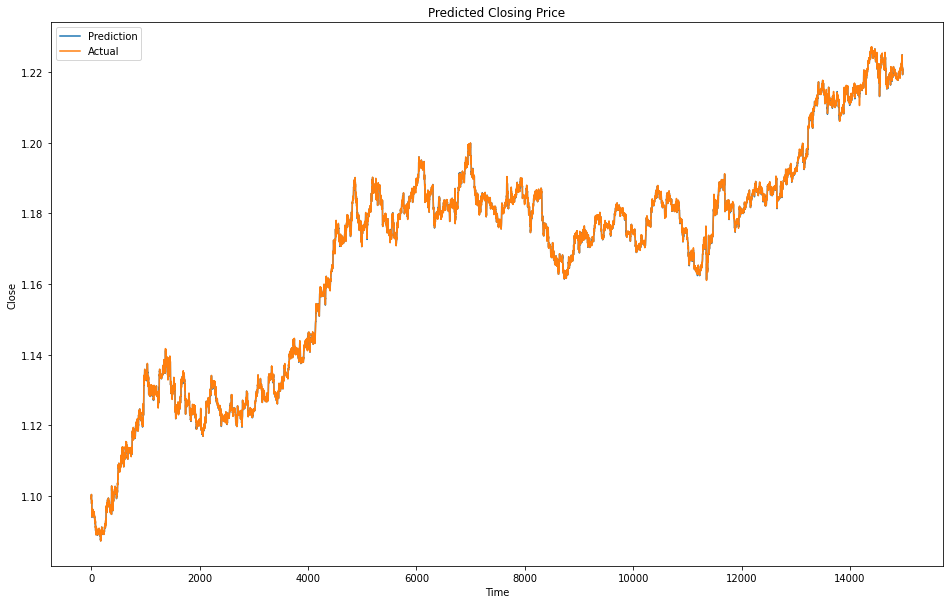

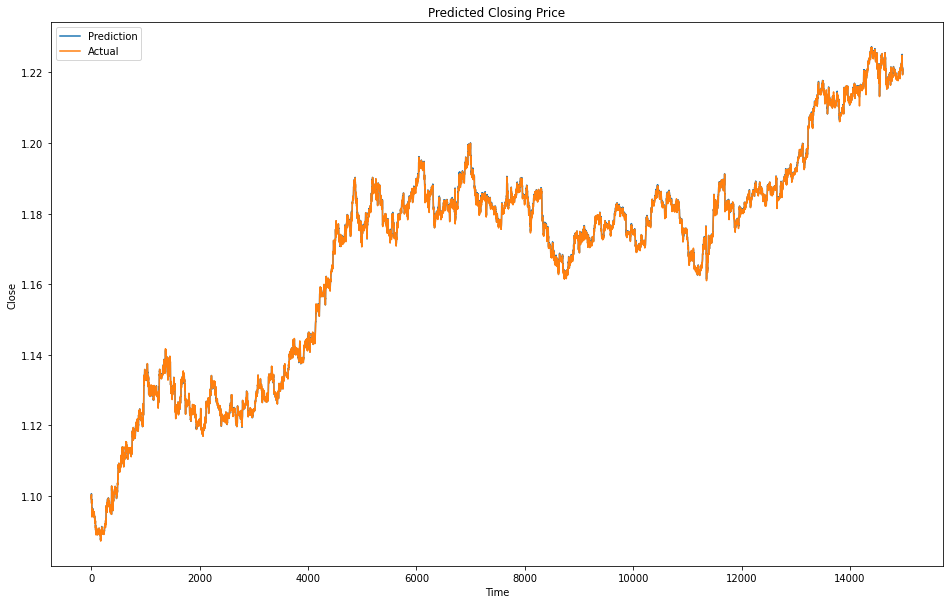

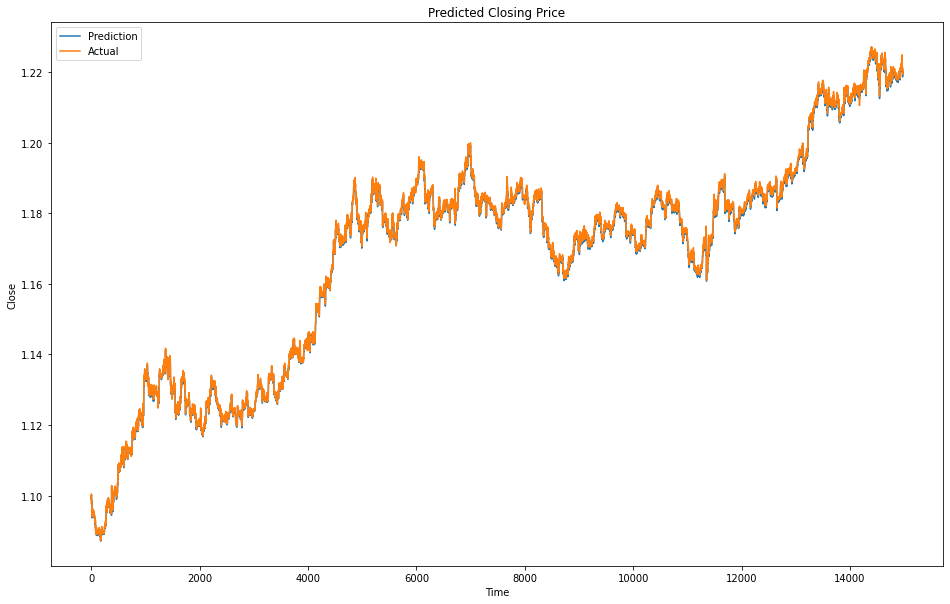

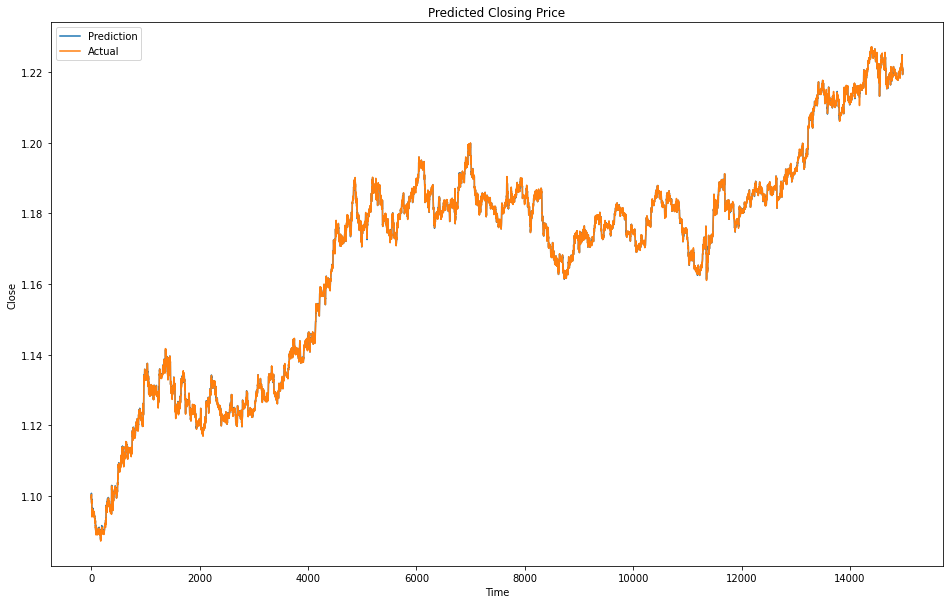

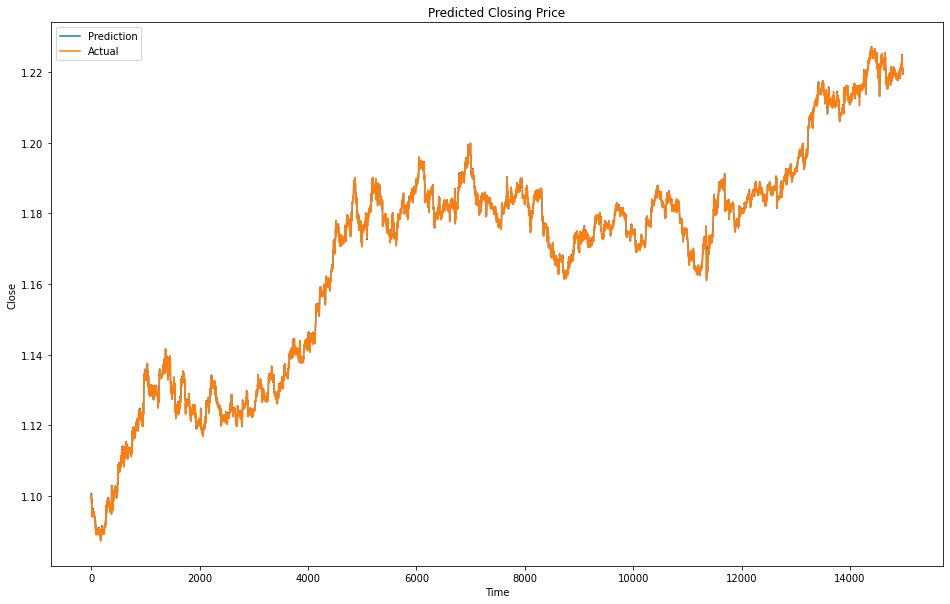

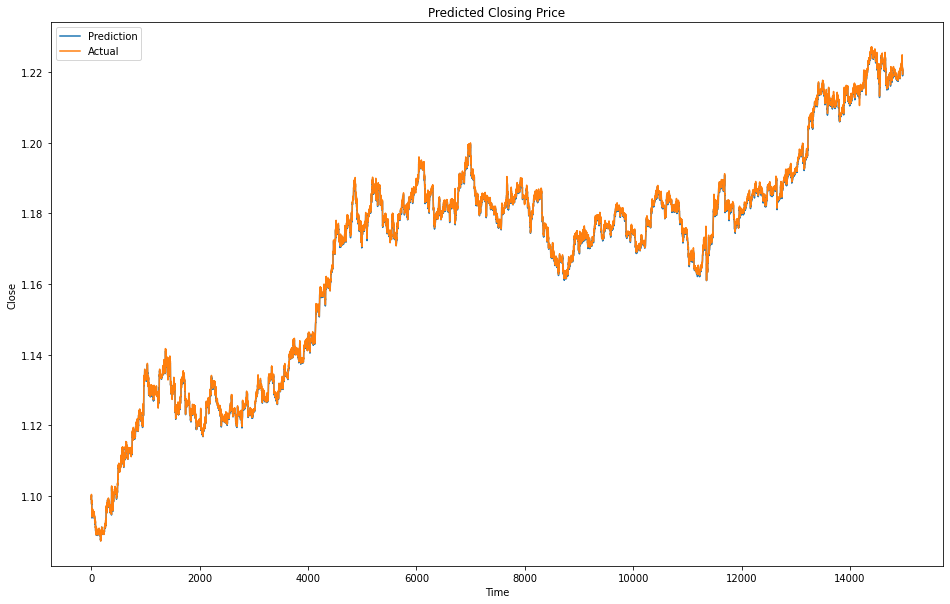

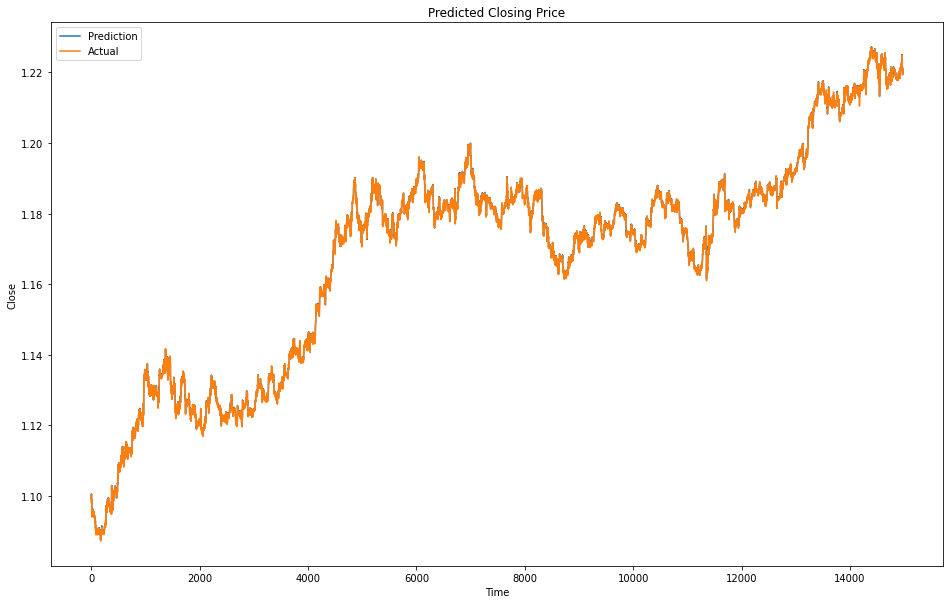

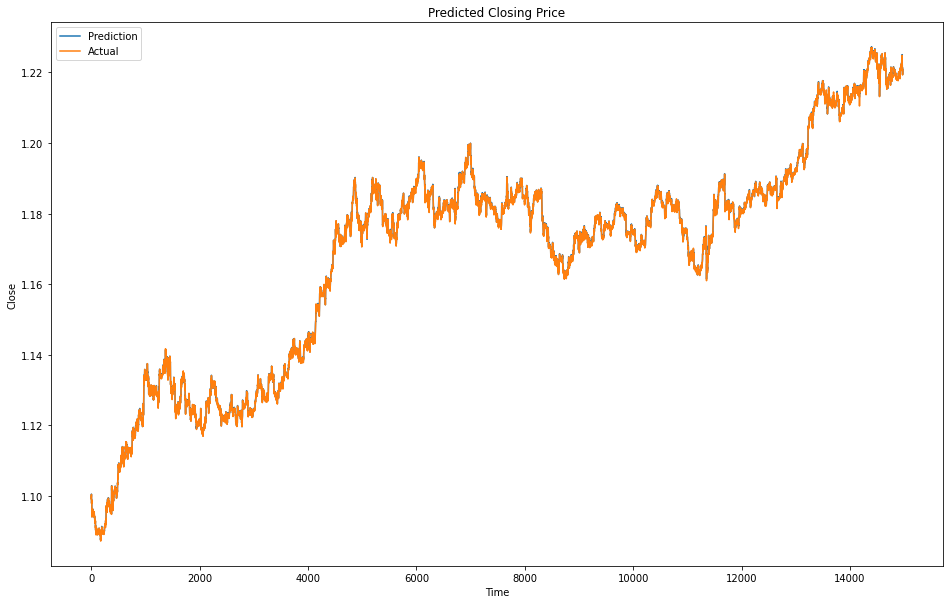

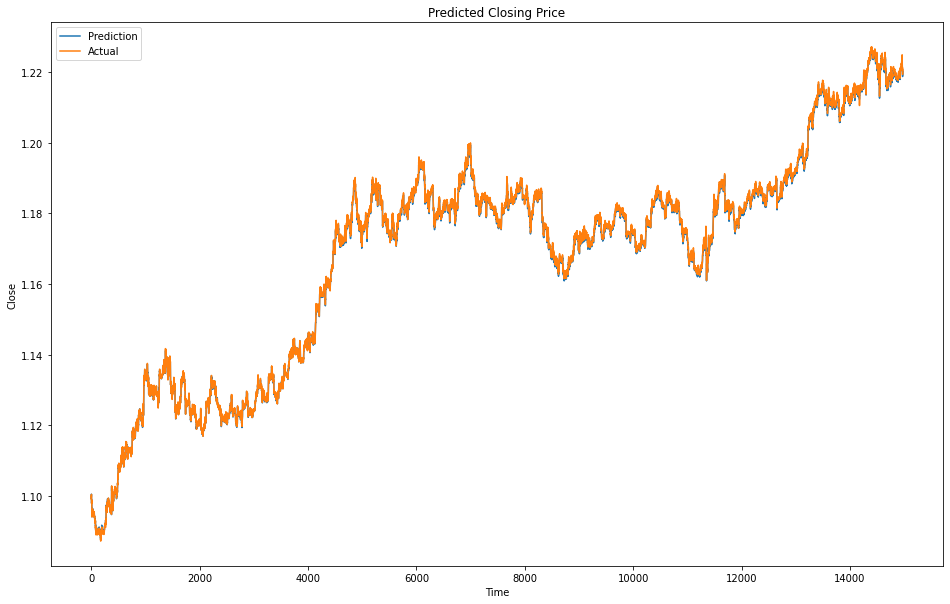

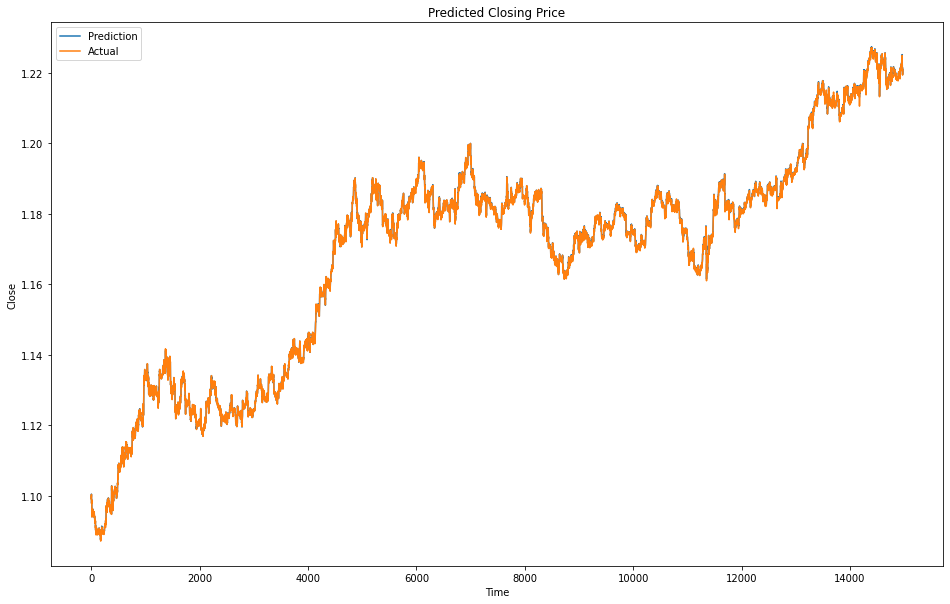

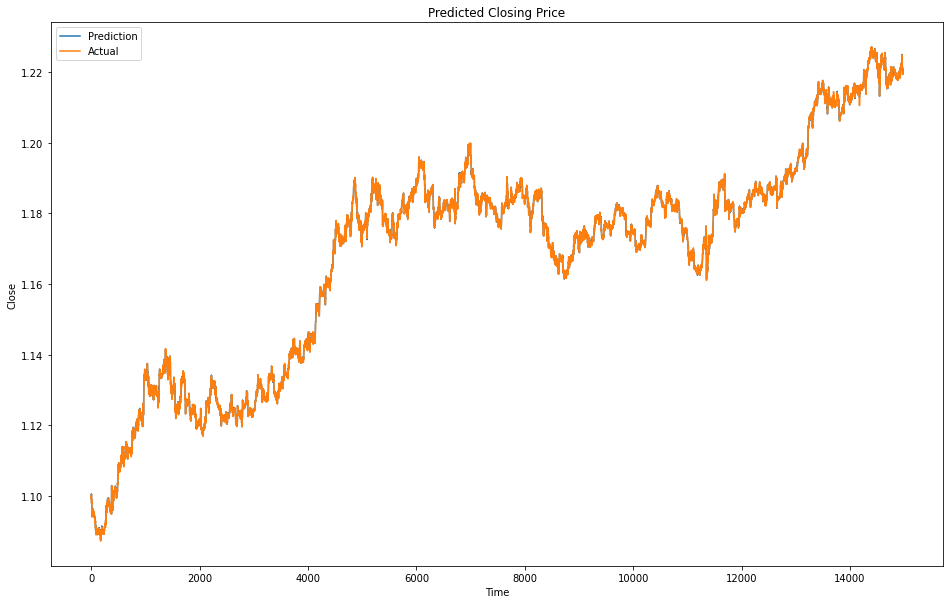

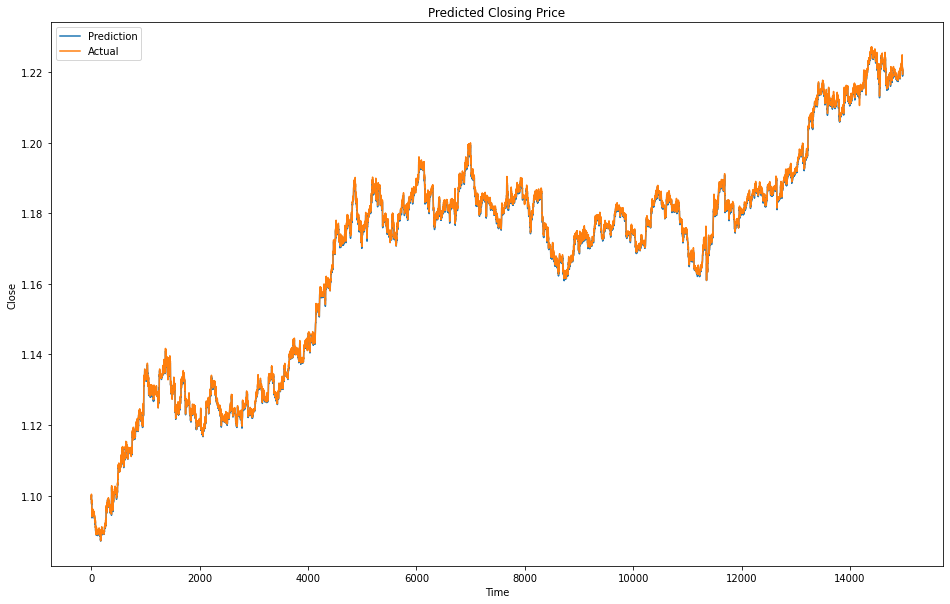

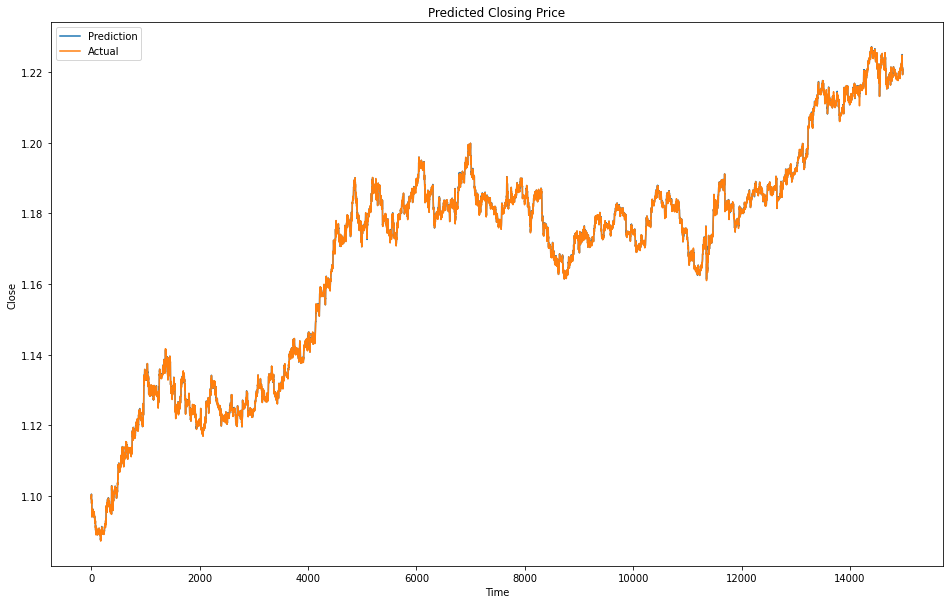

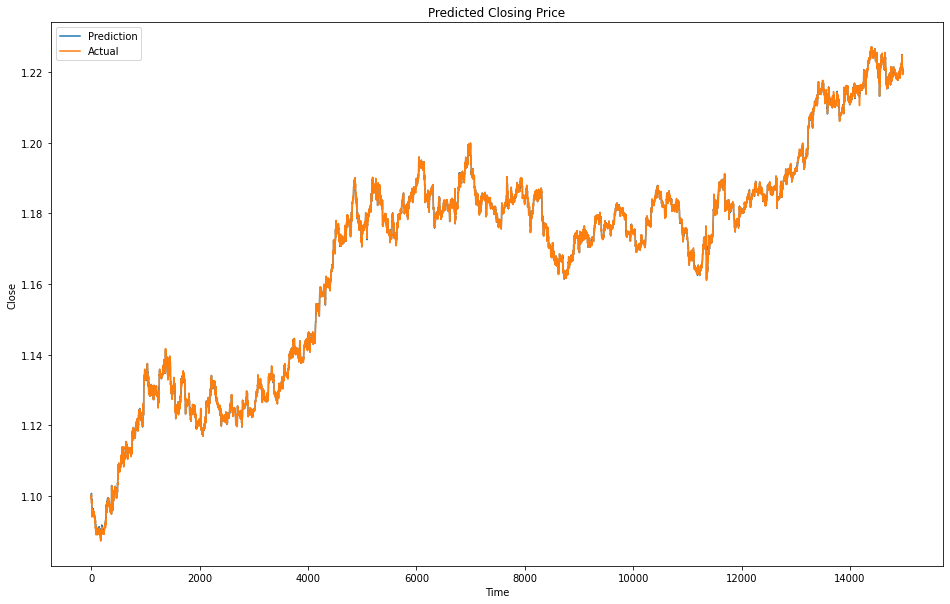

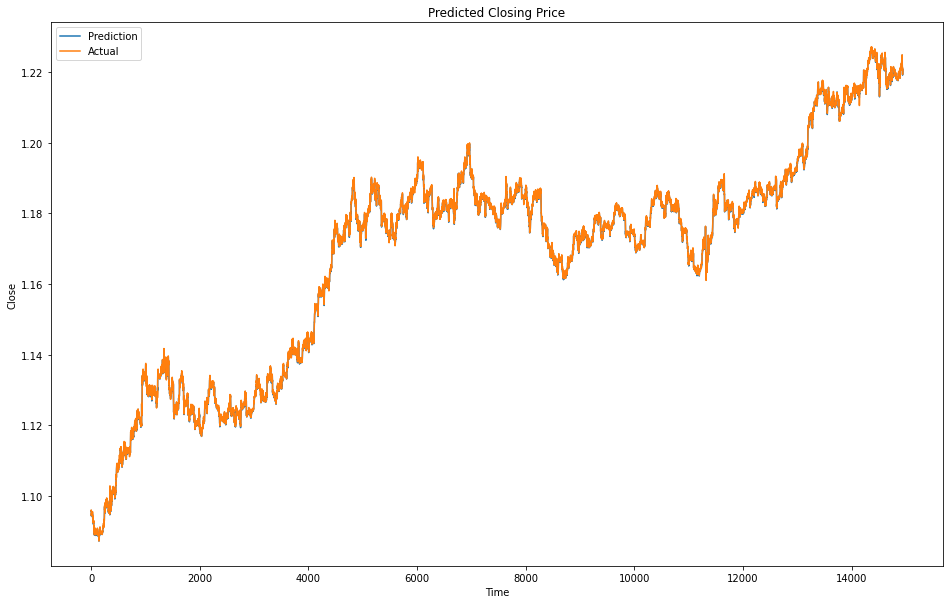

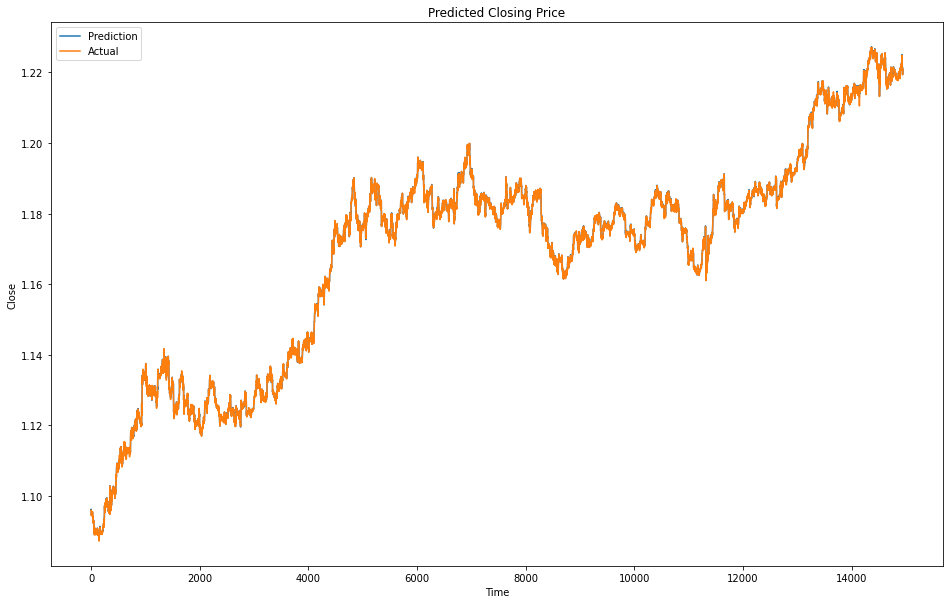

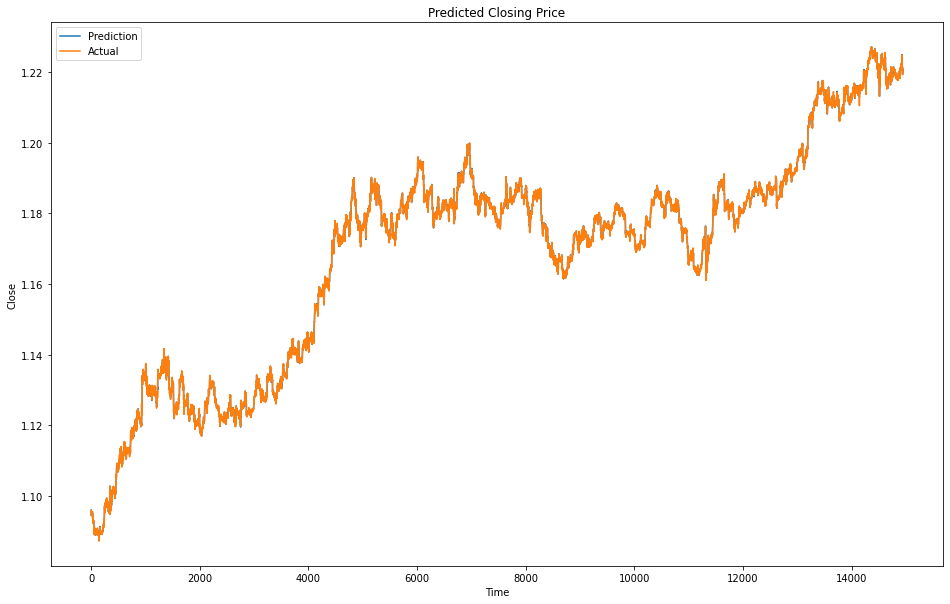

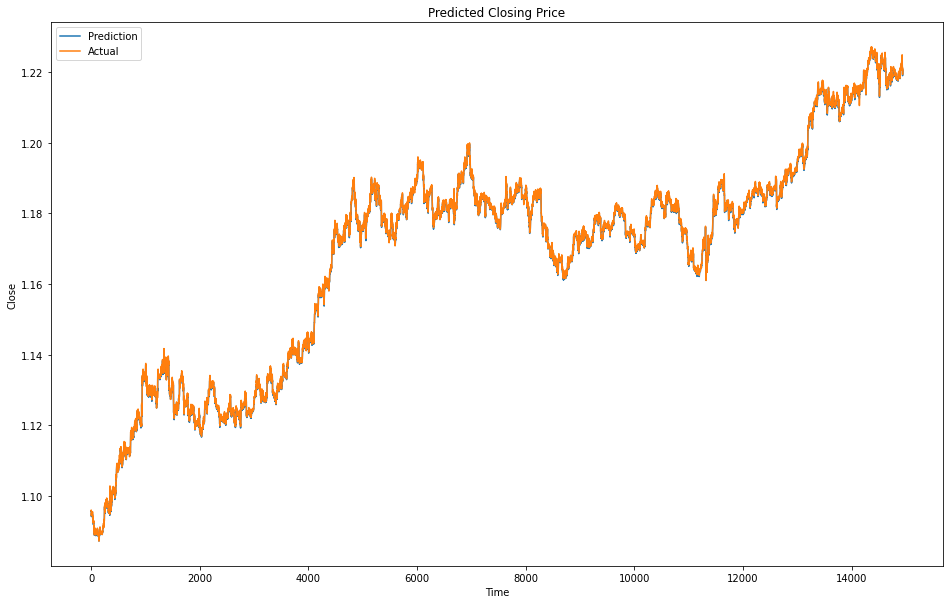

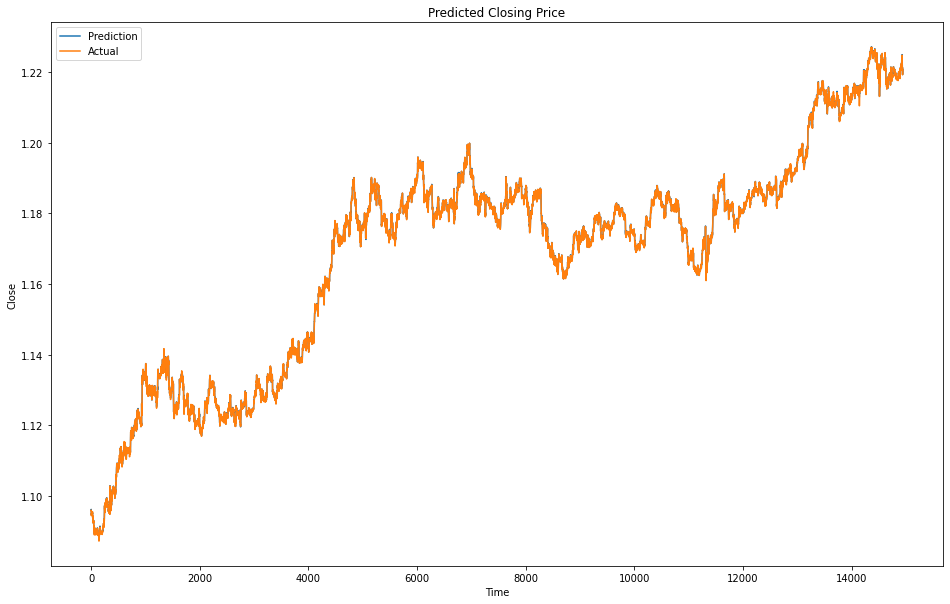

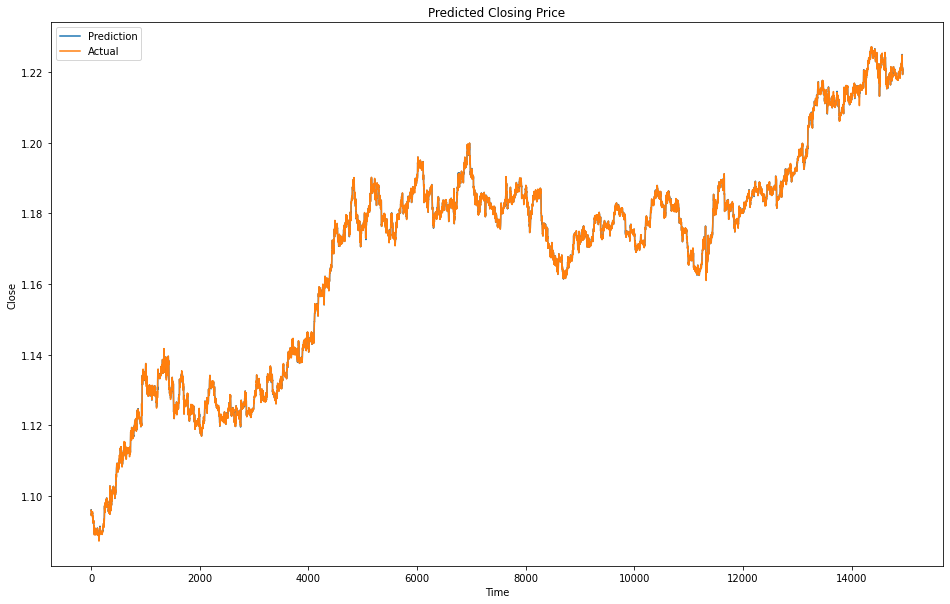

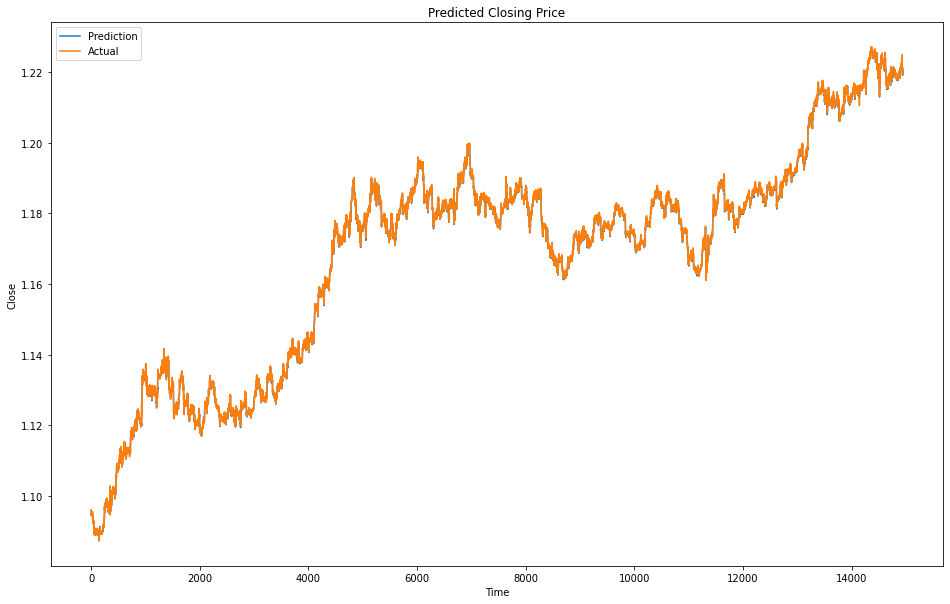

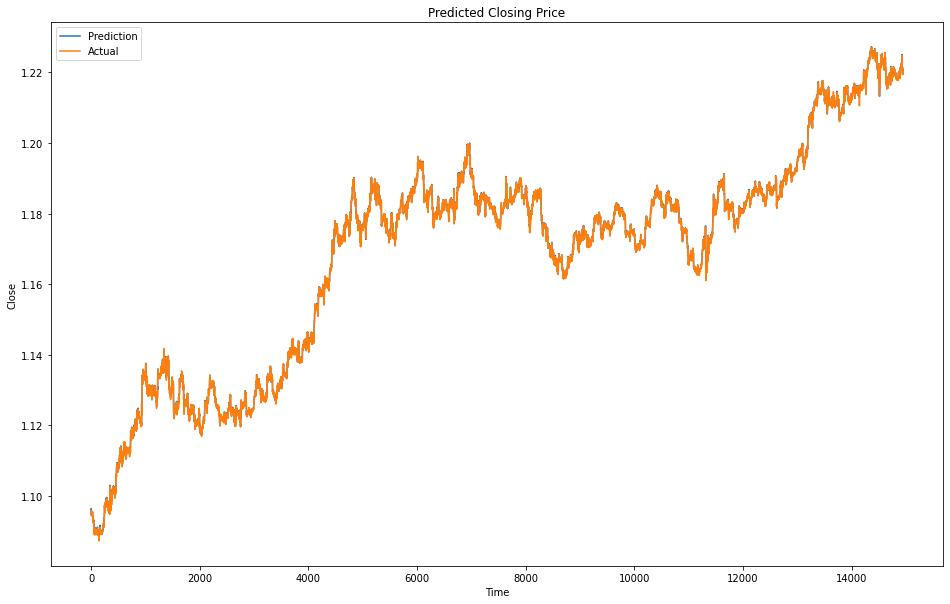

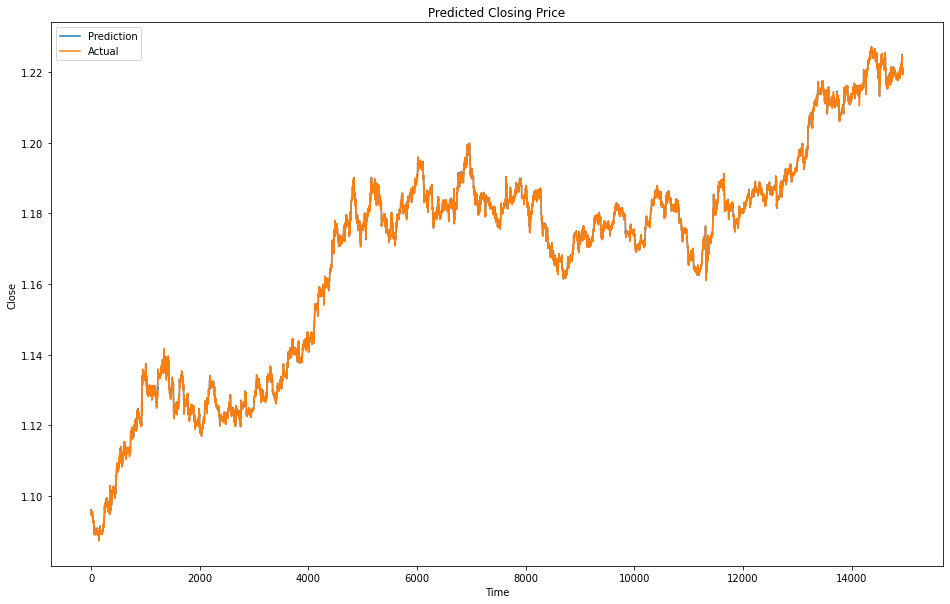

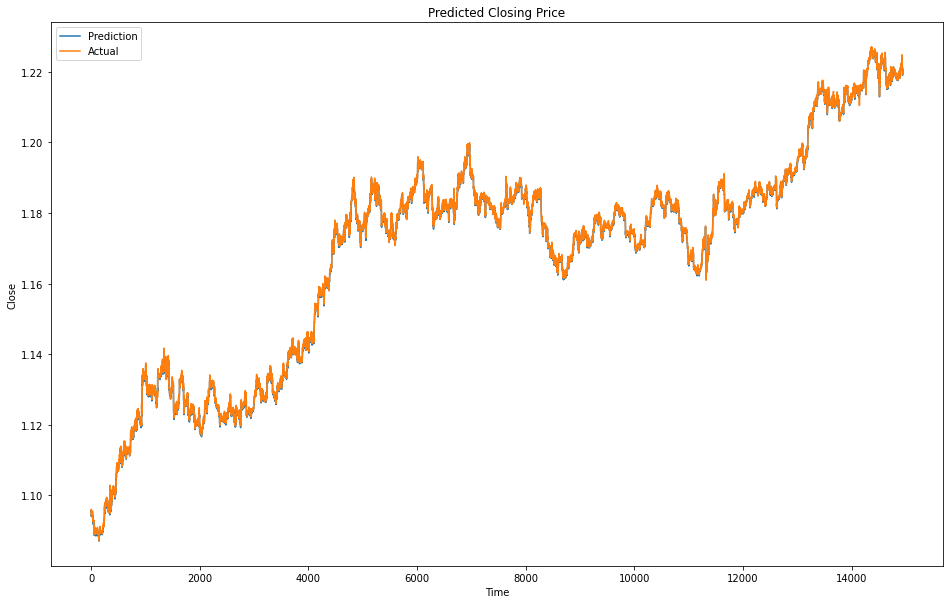

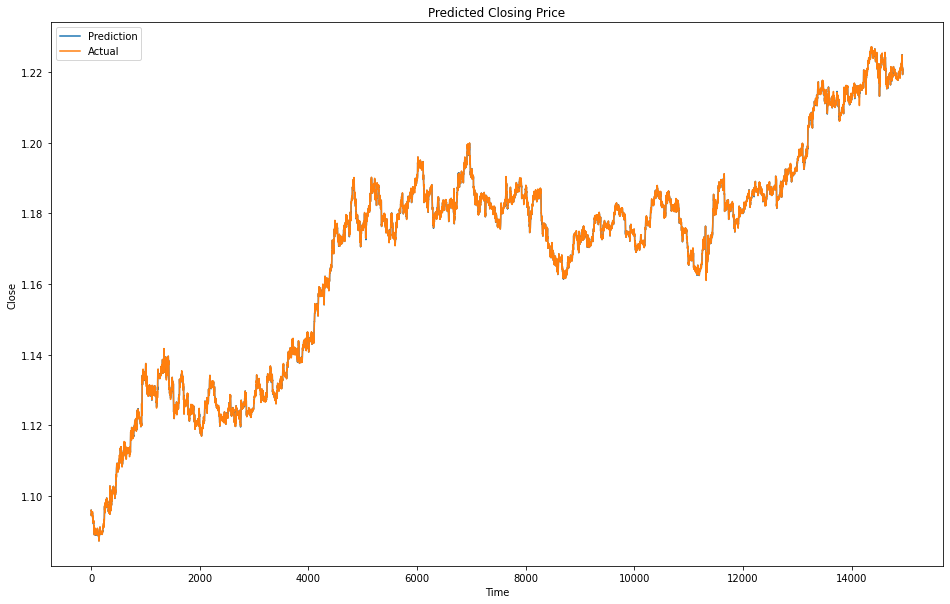

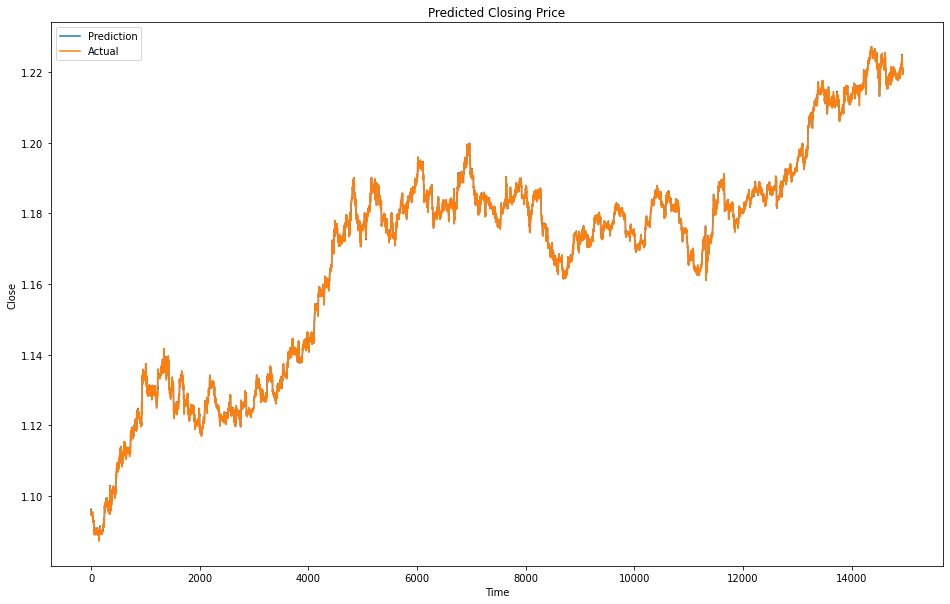

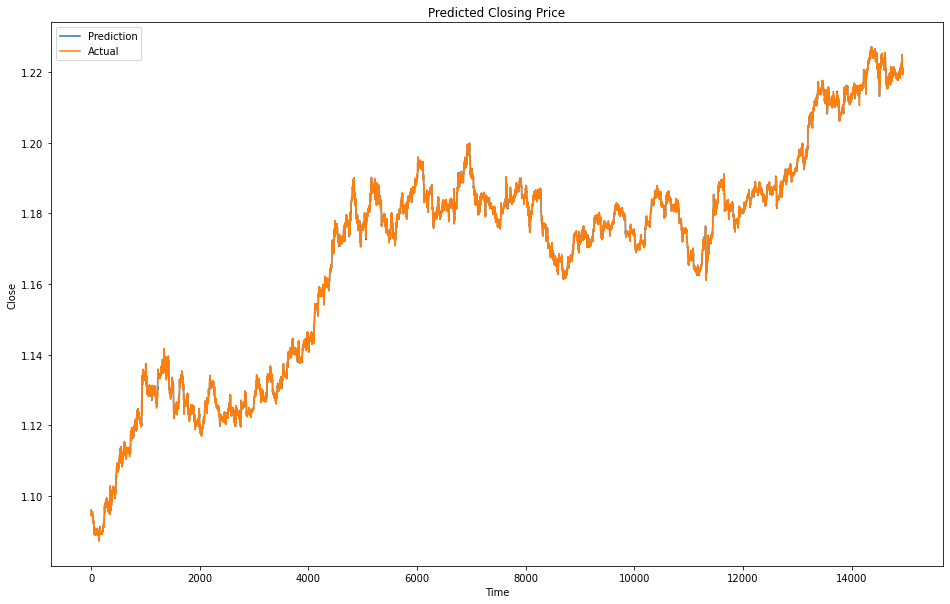

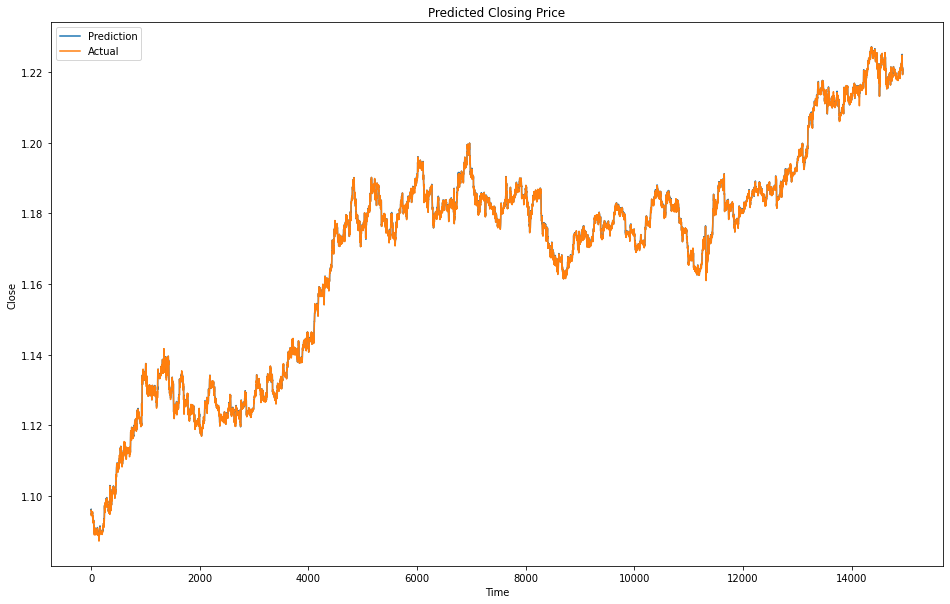

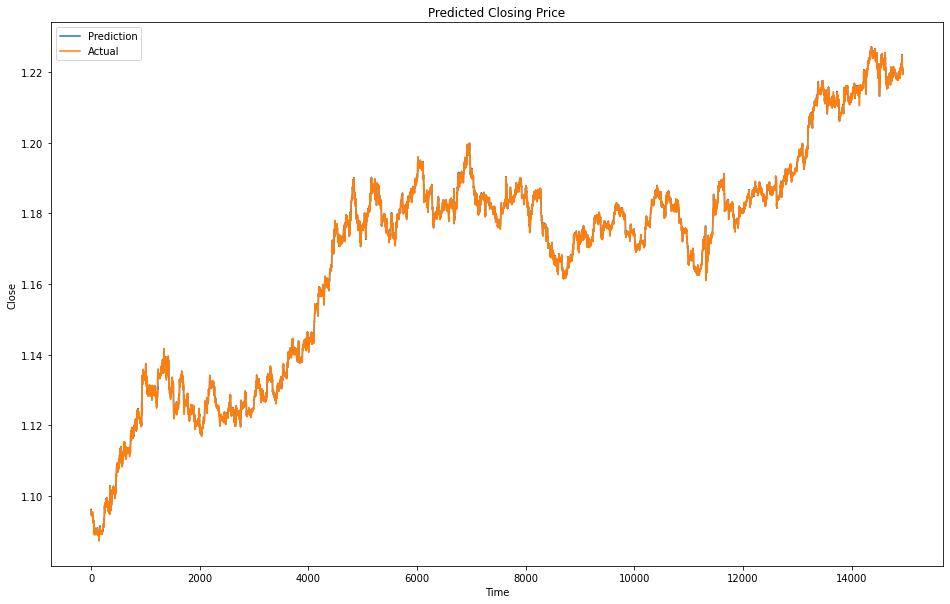

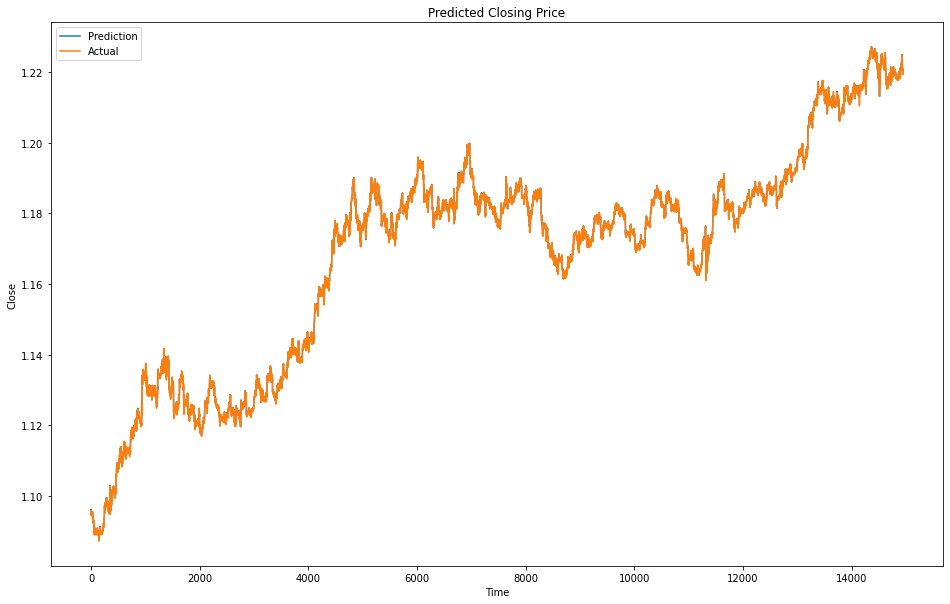

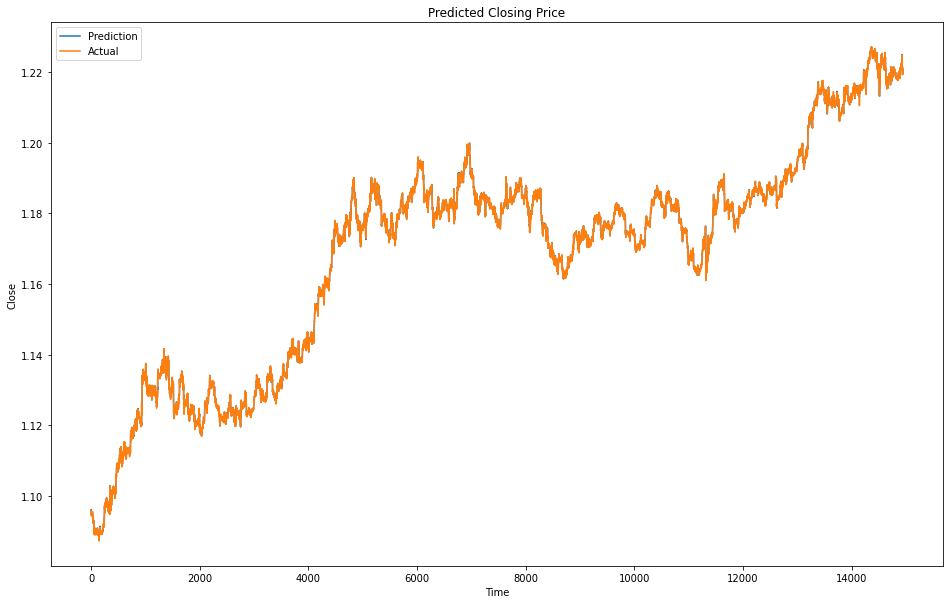

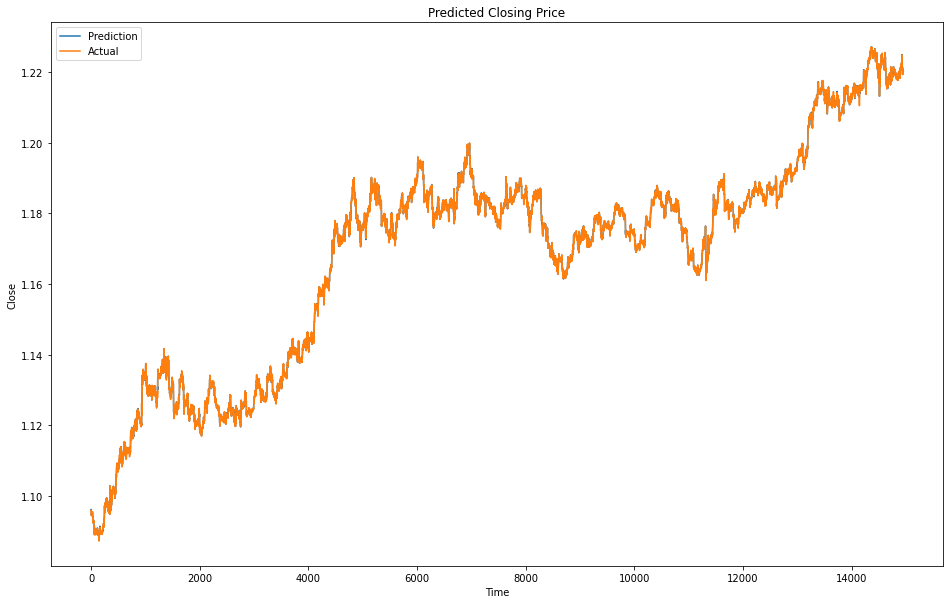

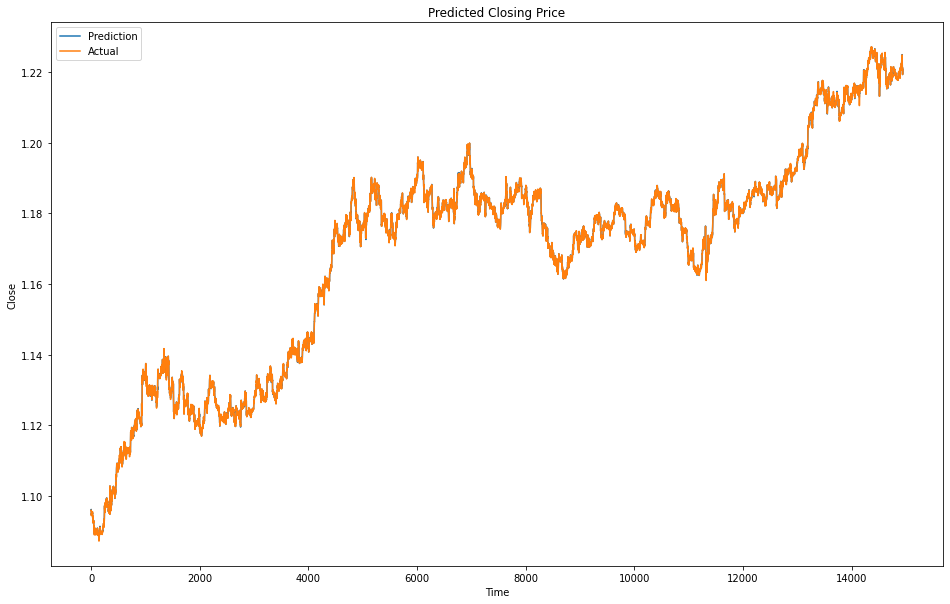

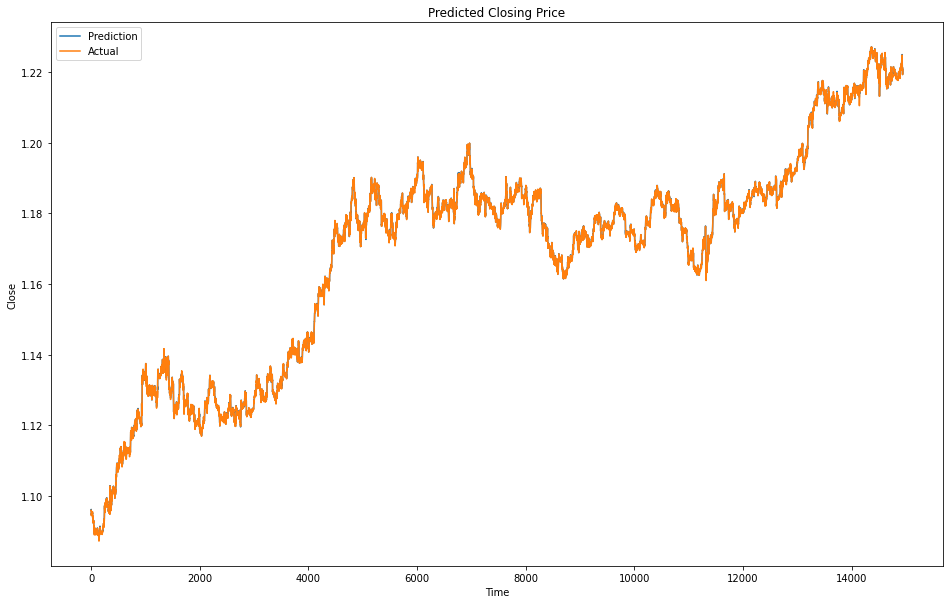

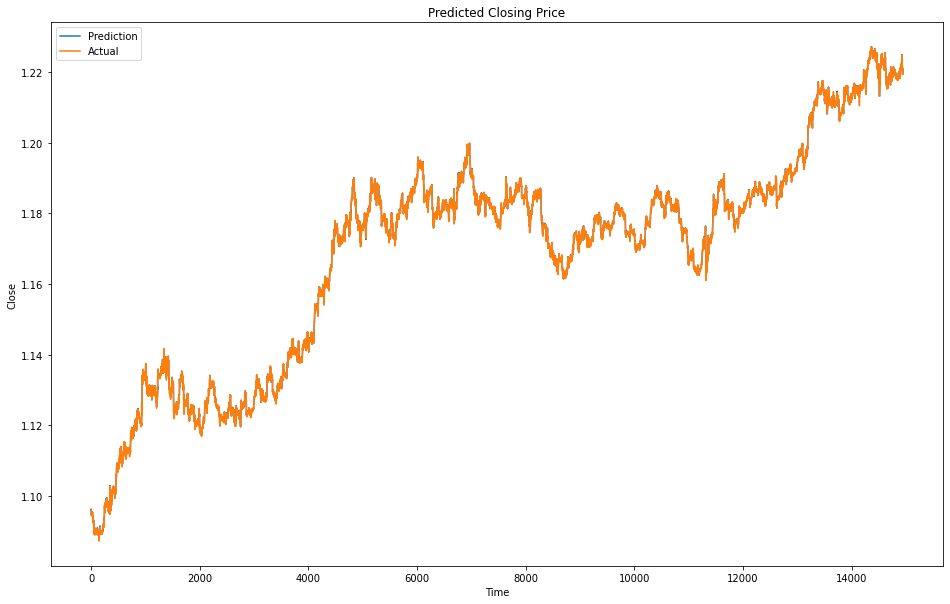

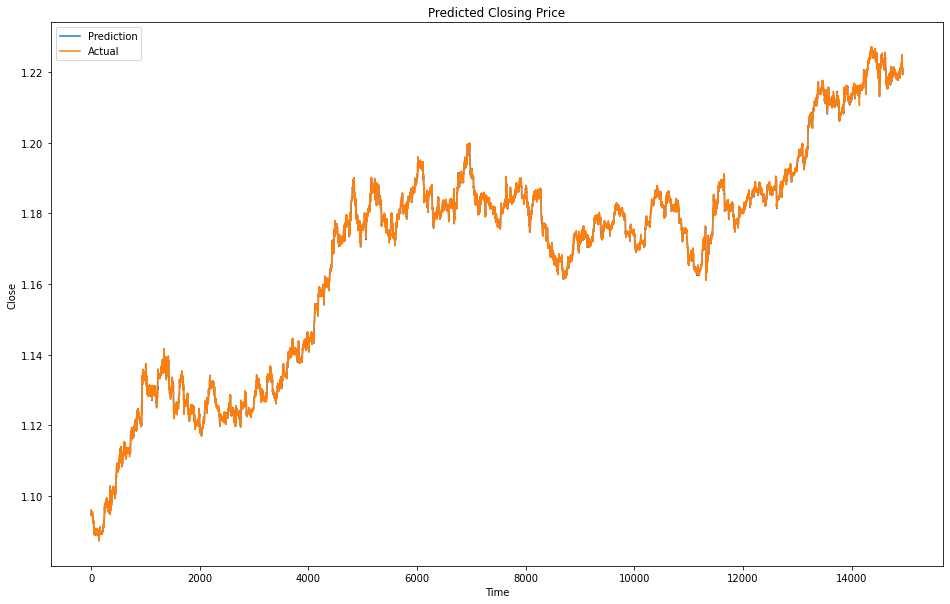

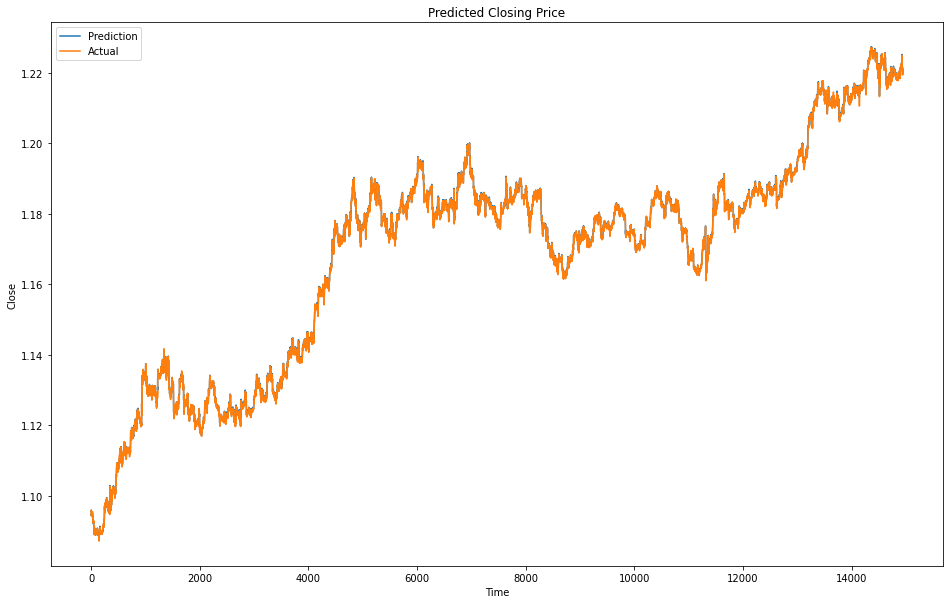

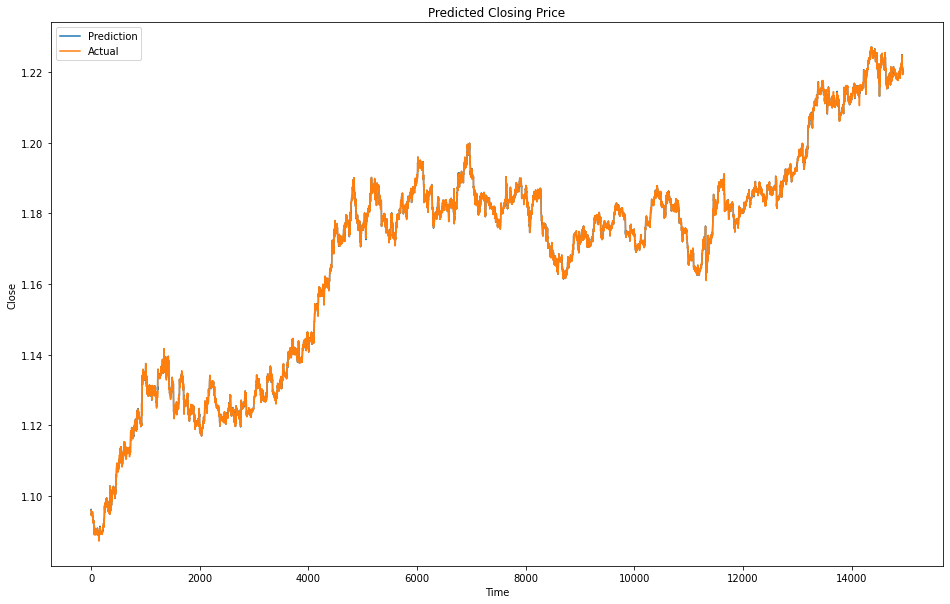

In [3]:
batch_size = [128, 64, 32, 16]
window_size = 320
time = 15
nodes = [[64, 32], [128, 64], [80, 64], [32, 16]]
optimizer = keras.optimizers.Adam(learning_rate=0.001)
dropout = [0, 0.1, 0.2]
counter = 0

for batch in batch_size:
    for node in nodes:
        for droppct in dropout:
            train_model("EURUSD", batch, window_size, time, node, optimizer, droppct)

In [ ]:
tensorboard --logdir logs/tuning

Launching TensorBoard...

In [2]:
series = pd.read_csv("../data/processed/EURUSD_processed.csv")

In [3]:
series.shape

(74716, 25)

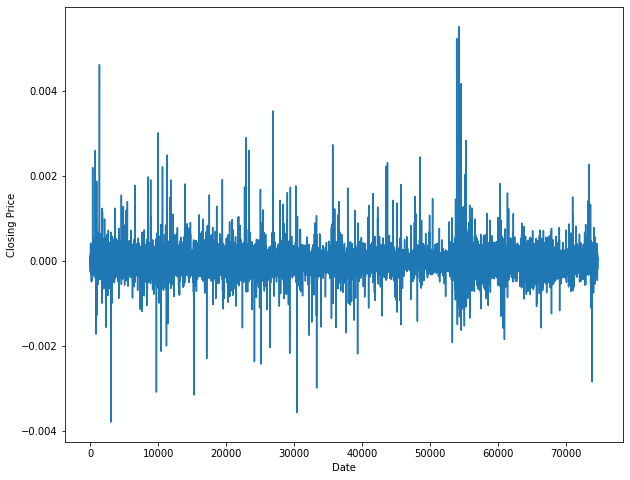

In [4]:
plt.figure(figsize=(10, 8))
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.plot(series.index[:], series["Close"][:])

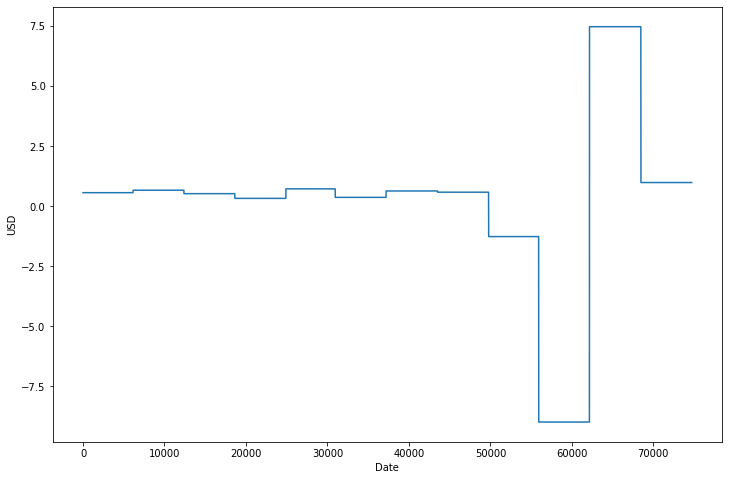

In [5]:
plt.figure(figsize=(12, 8))
plt.xlabel("Date")
plt.ylabel("USD")
plt.plot(series.index, series["USD_GDP"])

In [6]:
batch_size = 32
series = series[series.shape[0] % batch_size:]
close = series[['Real Close']]
series = series.drop(['Time', 'Real Close'], axis=1)
series = series[{'Close', 'EMA_10', 'EMA_100', 'RSI', 'A/D Index',
                 'USD_PPI', 'EUR_PPI', 'USD Interest Rate', 'EUR Interest Rate',
                 'EUR Twitter Sentiment', 'USD Twitter Sentiment', 'USD_CPI', 'EUR_CPI'}]
#series = series.drop(['Volume', 'USD_PPI', 'EUR_PPI', "EUR News Sentiment", "USD News Sentiment",
#                      'High', 'Low', 'Open', 'EUR Unemployment Rate', 'USD Unemployment Rate',
#                      'EUR_CPI', 'USD_CPI'], axis=1)
series

,RSI,EUR Twitter Sentiment,EMA_10,EUR Interest Rate,EMA_100,Close,EUR_PPI,USD_PPI,USD Interest Rate,USD Twitter Sentiment,EUR_CPI,A/D Index,USD_CPI
28,48.033931,0.001546,-0.000007,1.0339,8.589786e-07,-0.000050,0.005859,0.012921,2.58,-0.002077,1.3,-51.000000,2.070508
29,63.780766,0.001494,0.000005,1.0339,3.126905e-06,-0.000008,0.005859,0.012921,2.58,-0.002008,1.3,-17.000000,2.070508
30,73.808000,0.001446,0.000021,1.0339,5.812042e-06,0.000008,0.005859,0.012921,2.58,-0.001944,1.3,22.200000,2.070508
31,85.524026,0.001401,0.000028,1.0339,1.060199e-05,0.000042,0.005859,0.012921,2.58,-0.001883,1.3,7.363636,2.070508
32,69.709314,0.001359,0.000026,1.0339,1.312112e-05,-0.000008,0.005859,0.012921,2.58,-0.001826,1.3,-178.000000,2.070508
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74711,44.066916,0.000000,-0.000014,-0.0913,-2.539624e-06,0.000000,0.001949,0.022647,0.93,-0.001073,-0.3,-27.000000,1.362005
74712,46.002475,0.000000,-0.000012,-0.0913,-2.634831e-06,-0.000057,0.001949,0.022647,0.93,-0.000852,-0.3,-26.173913,1.362005
74713,67.353758,0.000000,0.000053,-0.0913,1.120054e-05,-0.000196,0.001949,0.022647,0.93,-0.000852,-0.3,-212.000000,1.362005
74714,54.013982,0.000000,0.000006,-0.0913,4.350334e-06,0.000090,0.001949,0.022647,0.93,-0.000852,-0.3,76.142857,1.362005


In [8]:
window_size = batch_size * 15
df_train, df_val, df_test = create_split(series, 0.8, 0.2)
print(f'df_train.shape {df_train.shape}, df_validation.shape {df_val.shape}, df_test.shape {df_test.shape}')

df_train.shape (47776, 13), df_validation.shape (12448, 13), df_test.shape (15424, 13)


In [9]:
df_val

,RSI,EUR Twitter Sentiment,EMA_10,EUR Interest Rate,EMA_100,Close,EUR_PPI,USD_PPI,USD Interest Rate,USD Twitter Sentiment,EUR_CPI,A/D Index,USD_CPI
47324,43.551661,-0.000983,-0.000007,0.3050,-7.040667e-06,0.000173,0.000000,-0.000509,1.81,0.003141,1.0,170.000000,2.051278
47325,37.870700,-0.000983,-0.000017,0.3050,-9.835056e-06,0.000027,0.000000,-0.000509,1.81,0.003141,1.0,0.000000,2.051278
47326,52.730809,-0.000983,0.000010,0.3050,-4.188040e-06,0.000018,0.000000,-0.000509,1.81,0.003141,1.0,169.000000,2.051278
47327,53.370528,-0.000983,-0.000006,0.3050,-7.879561e-07,0.000036,0.000000,-0.000509,1.81,0.002967,1.0,6.000000,2.051278
47328,43.498461,-0.000983,-0.000021,0.3050,-1.846631e-06,-0.000100,0.000000,-0.000509,1.81,0.002827,1.0,-81.230769,2.051278
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59767,30.529619,-0.001135,-0.000026,0.4796,-1.369979e-05,-0.000119,-0.001965,-0.032192,0.67,-0.001102,0.1,-107.000000,0.117926
59768,35.483376,-0.001135,-0.000009,0.4796,-1.454096e-05,-0.000073,-0.001965,-0.032192,0.67,-0.000754,0.1,-149.000000,0.117926
59769,29.748099,-0.001135,-0.000014,0.4796,-1.746159e-05,-0.000009,-0.001965,-0.032192,0.67,-0.000489,0.1,-122.000000,0.117926
59770,57.859185,-0.000870,0.000011,0.4796,-6.464536e-06,0.000009,-0.001965,-0.032192,0.67,-0.000865,0.1,38.750000,0.117926


In [10]:
closeScaler = MinMaxScaler()
featureScaler = MinMaxScaler()
df_train = df_train.copy()
df_val = df_val.copy()
df_test = df_test.copy()
df_train.loc[:, ['Close']] = closeScaler.fit_transform(df_train[['Close']])
df_train.loc[:, ~df_train.columns.isin(['Close'])] = featureScaler.fit_transform(df_train.loc[:, ~df_train.columns.isin(['Close'])])
df_val.loc[:, ['Close']] = closeScaler.transform(df_val[['Close']])
df_val.loc[:, ~df_val.columns.isin(['Close'])] = featureScaler.transform(df_val.loc[:, ~df_val.columns.isin(['Close'])])
df_test.loc[:, ['Close']] = closeScaler.transform(df_test[['Close']])
df_test.loc[:, ~df_test.columns.isin(['Close'])] = featureScaler.transform(df_test.loc[:, ~df_test.columns.isin(['Close'])])

In [11]:
df_train

,RSI,EUR Twitter Sentiment,EMA_10,EUR Interest Rate,EMA_100,Close,EUR_PPI,USD_PPI,USD Interest Rate,USD Twitter Sentiment,EUR_CPI,A/D Index,USD_CPI
28,0.481880,0.740494,0.469479,0.651298,0.536779,0.445494,0.940717,0.789097,0.625000,0.398778,0.375,0.677187,0.385043
29,0.658978,0.734818,0.477978,0.651298,0.545779,0.450440,0.940717,0.789097,0.625000,0.403020,0.375,0.678853,0.385043
30,0.771750,0.729507,0.488654,0.651298,0.556435,0.452418,0.940717,0.789097,0.625000,0.406989,0.375,0.680774,0.385043
31,0.903515,0.724527,0.493901,0.651298,0.575444,0.456371,0.940717,0.789097,0.625000,0.410710,0.375,0.680047,0.385043
32,0.725654,0.719849,0.492528,0.651298,0.585441,0.450441,0.940717,0.789097,0.625000,0.414206,0.375,0.670963,0.385043
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47799,0.621709,0.635486,0.461381,0.210519,0.657721,0.436384,0.683689,0.357206,0.151316,0.482778,0.375,0.668820,0.535194
47800,0.745413,0.635486,0.496252,0.210519,0.697789,0.443915,0.683689,0.357206,0.151316,0.519251,0.375,0.668459,0.535194
47801,0.576860,0.635486,0.492349,0.210519,0.647166,0.483642,0.683689,0.357206,0.151316,0.503852,0.375,0.685261,0.535194
47802,0.553470,0.635486,0.484702,0.210519,0.621149,0.465386,0.683689,0.357206,0.151316,0.503852,0.375,0.690396,0.535194


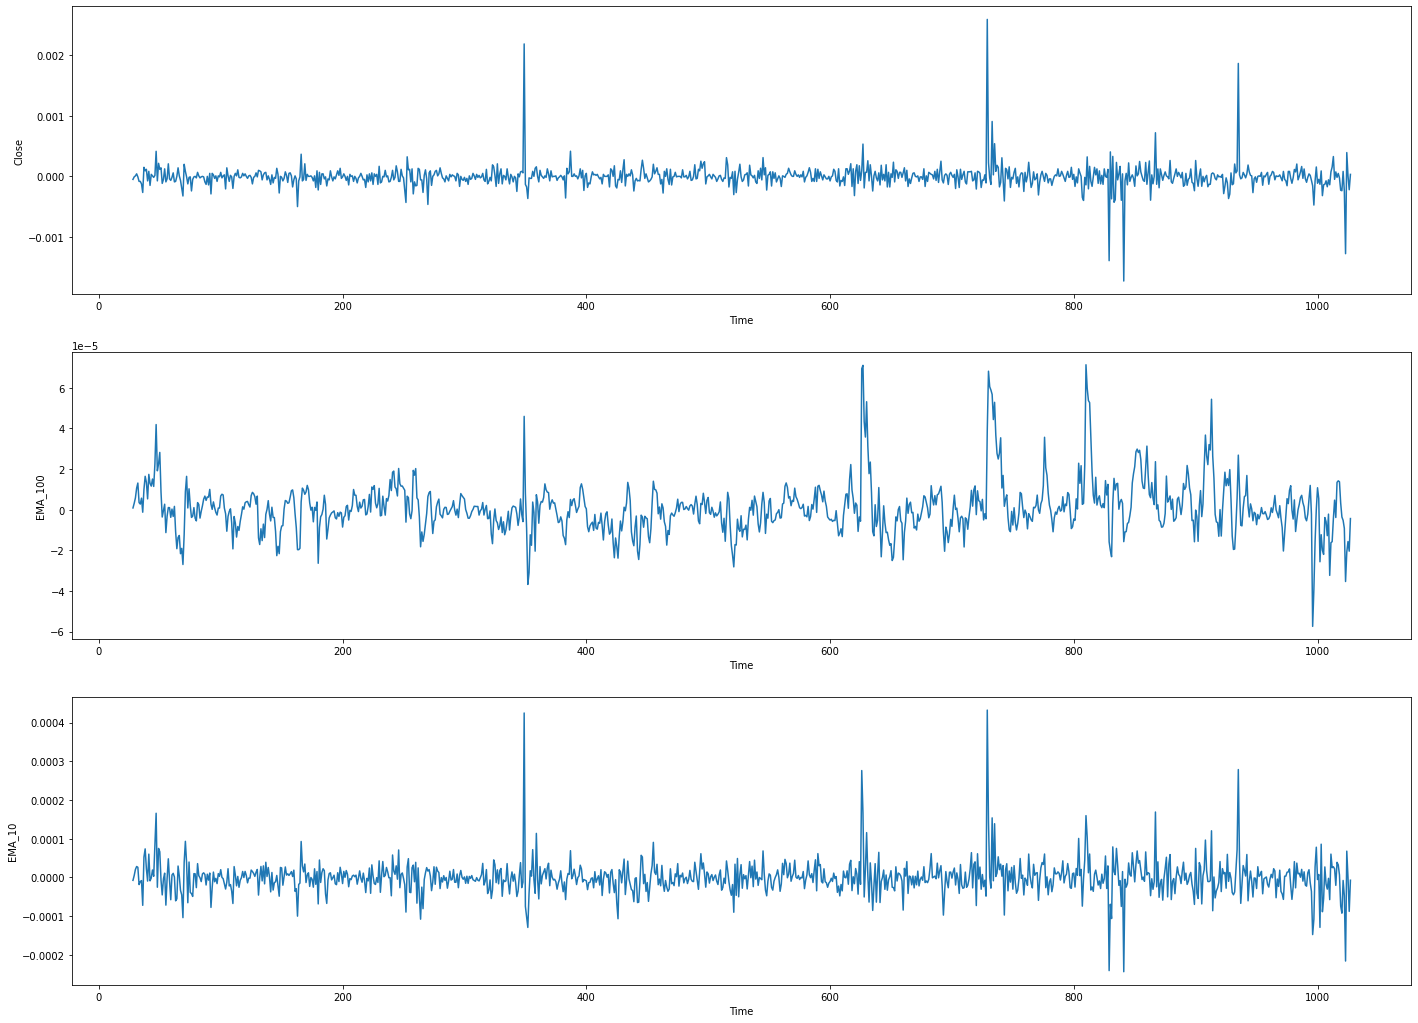

In [13]:
fig = plt.figure(figsize=(24, 18))
ax1, ax2, ax3 = fig.subplots(3)
ax1.set(xlabel='Time', ylabel='Close')
ax2.set(xlabel='Time', ylabel='EMA_100')
ax3.set(xlabel='Time', ylabel='EMA_10')
ax1.plot(series['Close'][:1000])
ax2.plot(series['EMA_100'][:1000])
ax3.plot(series['EMA_10'][:1000])

In [14]:
X_train, y_train = create_dataset(df_train, window_size)
X_val, y_val = create_dataset(df_val, window_size)
X_test, y_test = create_dataset(df_test, window_size)

In [15]:
X_train.shape

(47296, 480, 13)

In [16]:
model = keras.Sequential()
#model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(keras.layers.LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(32, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))
model.compile(loss="mse", optimizer='Adam', metrics=['mae'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='epoch', profile_batch=0)


In [17]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=5,
                    batch_size=batch_size,
                    shuffle=False,
                    callbacks=[tensorboard_callback]
                   )

Epoch 1/5
1478/1478 [==============================] - 384s 260ms/step - loss: 0.0029 - mae: 0.0387 - val_loss: 0.0030 - val_mae: 0.0409
Epoch 2/5
1478/1478 [==============================] - 402s 272ms/step - loss: 5.4595e-04 - mae: 0.0157 - val_loss: 5.7094e-04 - val_mae: 0.0142
Epoch 3/5
1478/1478 [==============================] - 407s 275ms/step - loss: 3.3517e-04 - mae: 0.0106 - val_loss: 5.7662e-04 - val_mae: 0.0139
Epoch 4/5
1478/1478 [==============================] - 419s 284ms/step - loss: 3.2414e-04 - mae: 0.0102 - val_loss: 5.4744e-04 - val_mae: 0.0131
Epoch 5/5
1478/1478 [==============================] - 421s 285ms/step - loss: 3.2387e-04 - mae: 0.0102 - val_loss: 5.4145e-04 - val_mae: 0.0130


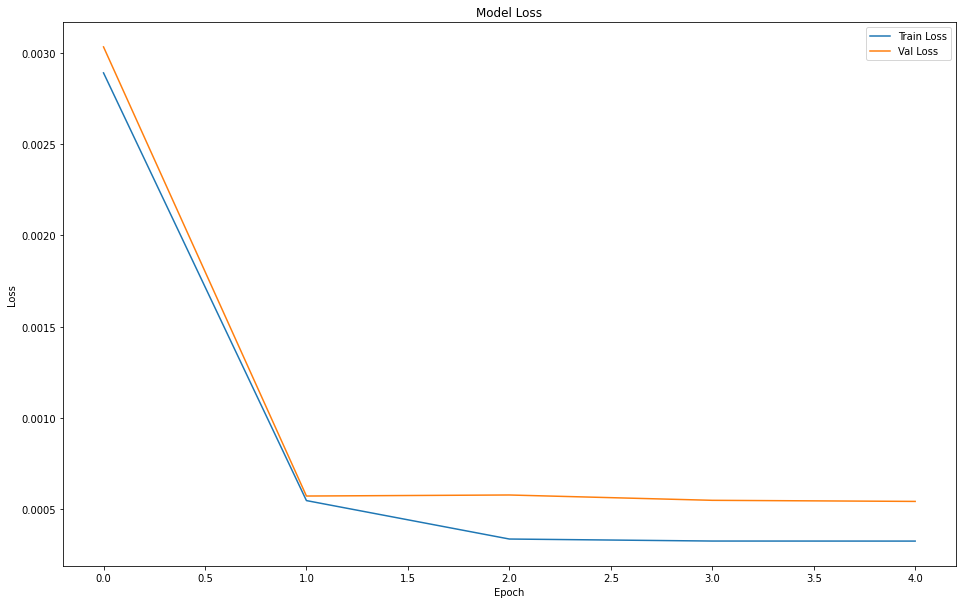

In [19]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.subplots(1)
ax1.set_title('Model Loss')
ax1.set(xlabel='Epoch', ylabel='Loss')
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.legend()

In [20]:
y_pred = model.predict(X_test)

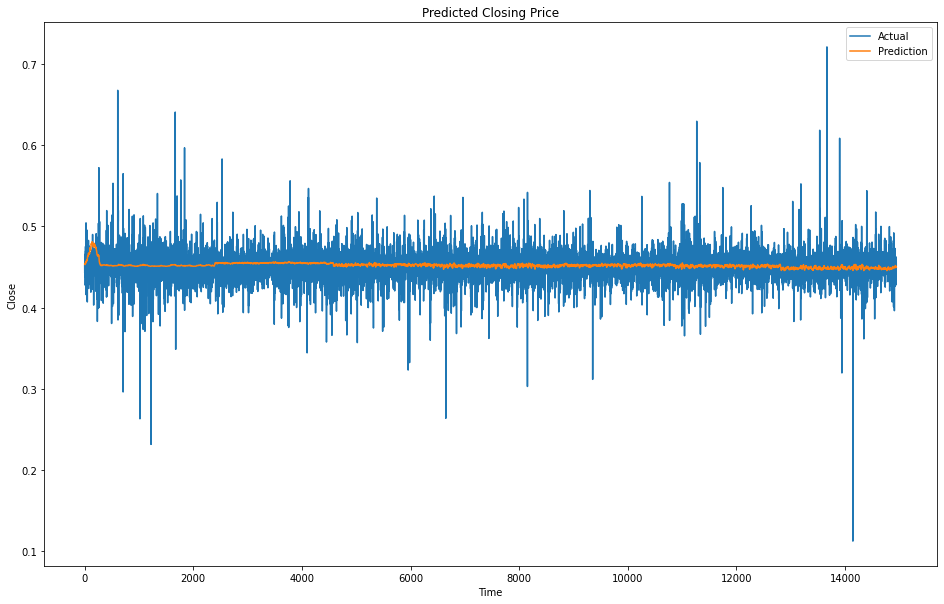

In [21]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.subplots(1)
ax1.set_title('Predicted Closing Price')
ax1.set(xlabel='Time', ylabel='Close')
ax1.plot(y_test, label='Actual')
ax1.plot(y_pred, label='Prediction')
ax1.legend()

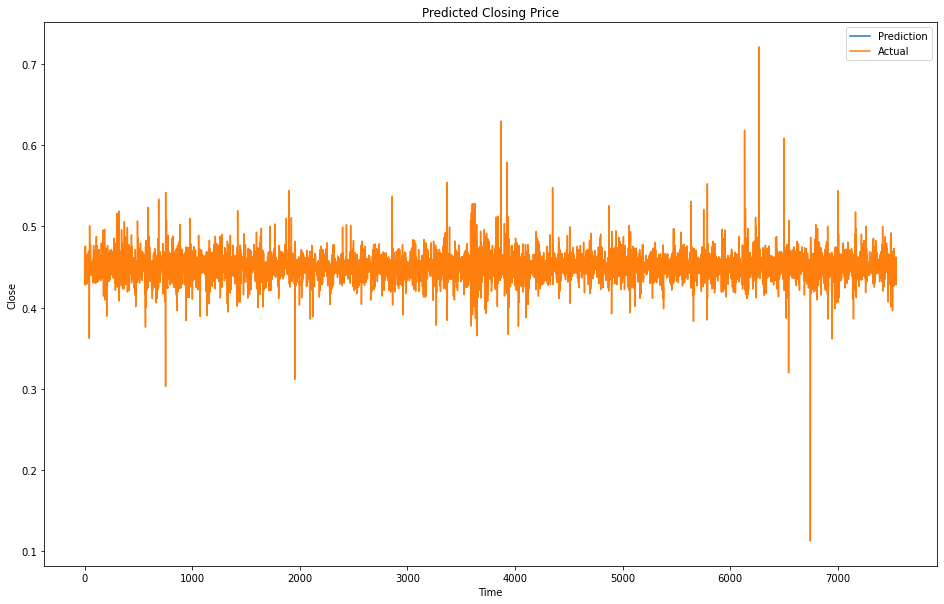

In [22]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.subplots(1)
ax1.set_title('Predicted Closing Price')
ax1.set(xlabel='Time', ylabel='Close')
ax1.plot(y_pred[7400:], label='Prediction')
ax1.plot(y_test[7400:], label='Actual')
ax1.legend()

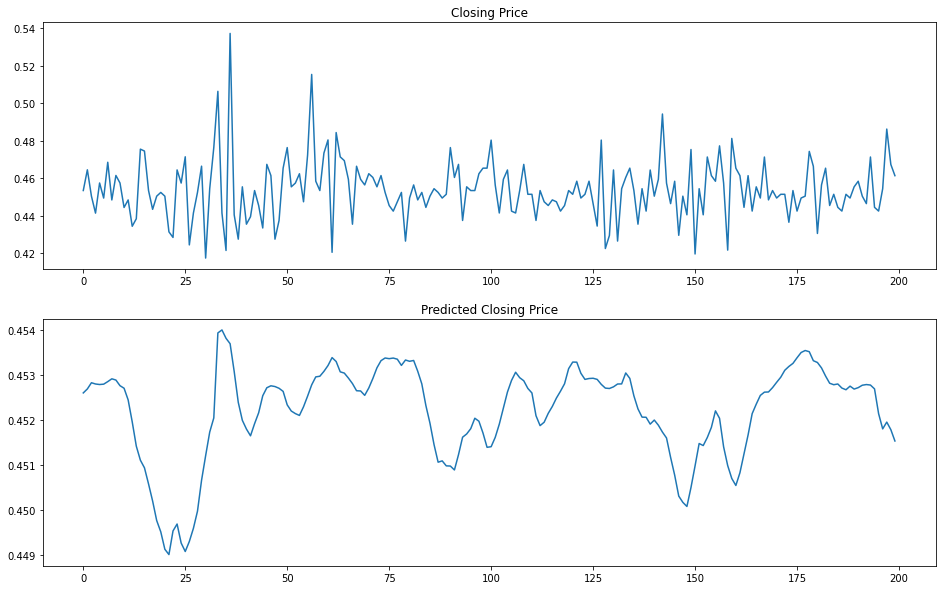

In [23]:
fig = plt.figure(figsize=(16, 10))
ax1, ax2 = fig.subplots(2)
ax1.set_title('Closing Price')
ax2.set_title('Predicted Closing Price')
ax2.plot(y_pred[6400:6600])
ax1.plot(y_test[6400:6600])

In [24]:
y_pred = model.predict(X_test)

In [25]:
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error:", mse)

467/467 [==============================] - 38s 82ms/step - loss: 3.1769e-04 - mae: 0.0116
Mean Squared Error: [0.0003176938625983894, 0.011633241549134254]


In [26]:
y_pred.shape

(14944, 1)

In [27]:
index = [i for i in range(y_pred.shape[0])]
df_predicted = pd.DataFrame(closeScaler.inverse_transform(y_pred), columns=['Close'], index=index)
df_actual = pd.DataFrame(closeScaler.inverse_transform(y_test.reshape(-1, 1)), columns=['Close'], index=index)
print(df_predicted)
print(df_actual)

          Close
0      0.000017
1      0.000017
2      0.000015
3      0.000014
4      0.000013
...         ...
14939 -0.000007
14940 -0.000008
14941 -0.000008
14942 -0.000011
14943 -0.000014

[14944 rows x 1 columns]
          Close
0      0.000000
1     -0.000073
2     -0.000064
3      0.000000
4     -0.000082
...         ...
14939  0.000000
14940 -0.000057
14941 -0.000196
14942  0.000090
14943  0.000008

[14944 rows x 1 columns]


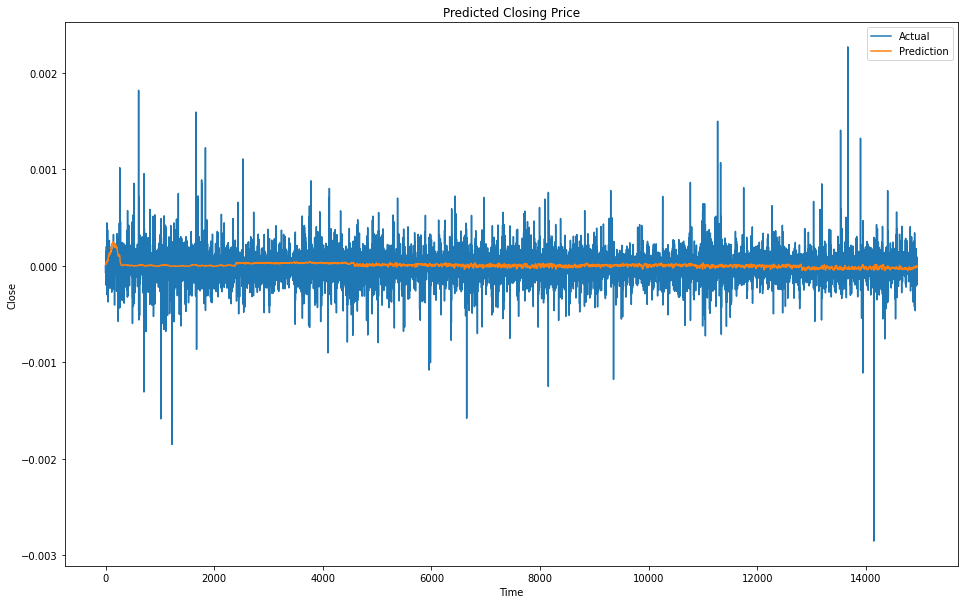

In [28]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.subplots(1)
ax1.set_title('Predicted Closing Price')
ax1.set(xlabel='Time', ylabel='Close')
ax1.plot(df_actual['Close'], label='Actual')
ax1.plot(df_predicted['Close'], label='Prediction')
ax1.legend()

In [29]:
df = pd.DataFrame(close['Real Close'][-y_pred.shape[0] - window_size:-window_size])
df.reset_index(inplace=True, drop=True)
df

,Real Close
0,1.09402
1,1.09438
2,1.09409
3,1.09396
4,1.09418
...,...
14939,1.22044
14940,1.22035
14941,1.22029
14942,1.22051


In [30]:
X_test.shape[0] + X_train.shape[0] + X_val.shape[0]

74208

In [31]:
df_predicted['Close'] = df['Real Close'].mul(np.exp(df_predicted['Close'].shift(-1))).shift(1)
df_actual['Close'] = df['Real Close'].mul(np.exp(df_actual['Close'].shift(-1))).shift(1)

In [32]:
print(df_actual['Close'])
print(df_predicted['Close'])

0            NaN
1        1.09394
2        1.09431
3        1.09409
4        1.09387
          ...   
14939    1.22038
14940    1.22037
14941    1.22011
14942    1.22040
14943    1.22052
Name: Close, Length: 14944, dtype: float64
0             NaN
1        1.094038
2        1.094397
3        1.094105
4        1.093974
           ...   
14939    1.220371
14940    1.220431
14941    1.220340
14942    1.220276
14943    1.220492
Name: Close, Length: 14944, dtype: float64


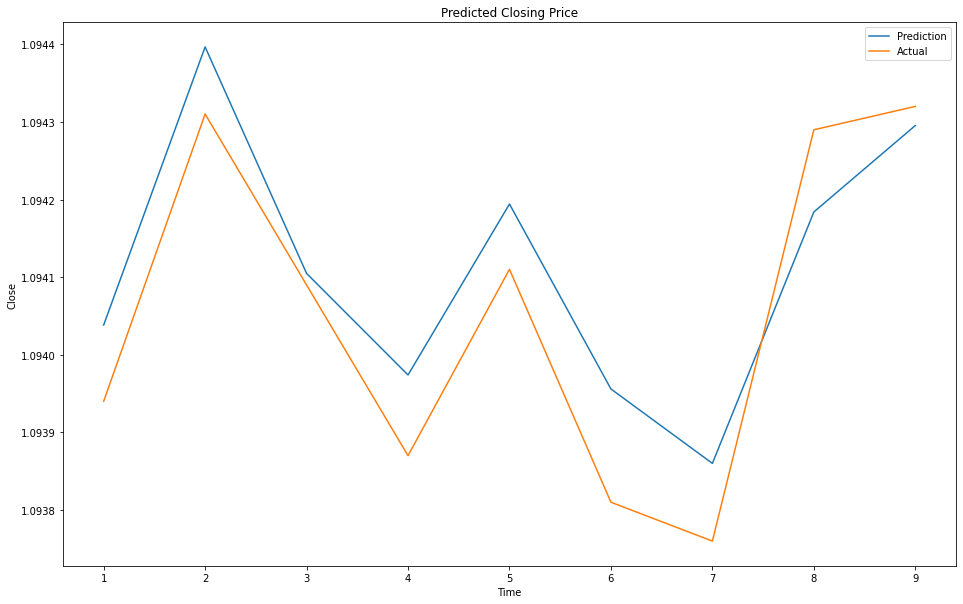

In [33]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.subplots(1)
ax1.set_title('Predicted Closing Price')
ax1.set(xlabel='Time', ylabel='Close')
ax1.plot(df_predicted['Close'][:10], label='Prediction')
ax1.plot(df_actual['Close'][:10], label='Actual')
ax1.legend()